# NSBH merger predictions

In [1]:
import sys
import matplotlib
import numpy as np
import math
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


from cycler import cycler

import scipy
from scipy import signal

import pycbc
import pycbc.catalog

import pylab
import gwosc

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal


#all type of waveform usable from lal suite (shure?)
from pycbc.waveform import td_approximants, fd_approximants

import GWFish.modules as gw

from tqdm import tqdm
import matplotlib


from astropy.cosmology import Planck18
from scipy.integrate import quad
import astropy.units as u

import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import os 
import pandas as pd
GWFish_path = 'GWFish/'



/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Mass models for the different components after the merger

In [2]:
def compactness_from_lambda(lambda_2):
    
    a0=0.360
    a1=-0.0355
    a2= 0.000705
    
    C_NS=a0+a1*np.log(lambda_2)**1+a2*np.log(lambda_2)**2  # Relation took from Yagi et al. (https://arxiv.org/pdf/1608.02582.pdf) 
    
    return C_NS

def compactness_from_lambda_classical(lambda_2):
    k2=0.2
    
    return ((2/3)*k2/lambda_2)**(1/5)

def R_ISCO_normalized(BHspin):
    
    Z1= 1+ (1-(BHspin**2))**(1/3)*((1+BHspin)**(1/3)+(1-BHspin)**(1/3))
    Z2= np.sqrt((3*BHspin**2)+Z1**2)
    
    R_ISCO_normalized= 3+Z2-np.sign(BHspin)*np.sqrt((3-Z1)*(3+Z1+2*Z2))
    
    return R_ISCO_normalized
    

In [3]:

def Remnant_mass_FF18(BHmass,NSmass,BHspin,lambda_2):
    """ This function computes the Remnant mass of the disk remaining after the NSBH merger.
        It taken from the Faucart et al. 2018 (https://arxiv.org/pdf/1807.00011.pdf). This formula
        cames from fitting Numerical simulation in that parameter space: Q=[1,7], BH_spin (chi)=[-0.5,0.97],
        C_NS (compactness)=[0.13,0.18]  

    Args:
        BHmass (_type_): _description_
        NSmass (_type_): _description_
        BHspin (_type_): _description_
        lambda_2 (_type_): _description_

    Returns:
        _type_: _description_
    """

    alpha=0.406
    beta=0.139
    gamma=0.255
    delta=1.761
    Q=BHmass/NSmass
    eta=Q/(1+Q)**2
    
    #if Q<1 or Q>7:
    #    print("Pay attention. Mass ratio Q is out of range for FF18 fitting formula.")
    
    #elif BHspin< -0.5 or BHspin >0.97:
    #    print("Pay attention. BH spin is out of range for FF18 fitting formula.")
    
    #elif C_NS<0.13 or C_NS > 0.18:
    #    print("Pay attention. Compactness C_NS is out of range for FF18 fitting formula.")
    
    #else:
    #    pass
    
    C_NS=compactness_from_lambda(lambda_2)
    R_ISCO= R_ISCO_normalized(BHspin)
    
    Baryonic_NS_mass=NSmass*(1.0+((0.6*C_NS)/(1-0.5*C_NS)))    
    
    result=(max((alpha*(eta)**(-1/3) * (1-2*C_NS)-beta*R_ISCO*(C_NS/eta)+gamma),0)**delta)*Baryonic_NS_mass
    
    return result

Remnant_mass_FF18_vectorized = np.vectorize(Remnant_mass_FF18)

In [5]:
def Dynamical_ejecta_mass(BHmass,NSmass,BHspin,lambda_2):
    """ This formula is taken from Oliver M. Boersma e al. (https://arxiv.org/pdf/2202.02181.pdf)
    """
    Q=BHmass/NSmass

    C_NS=compactness_from_lambda(lambda_2)
    R_ISCO= R_ISCO_normalized(BHspin)
    
    Barionic_NS_mass=NSmass*(1.0 +((0.6*C_NS)/(1-0.5*C_NS))) 
    #-------------------------------------------------------------------
    a1=0.007116
    a2=0.001436
    a4=-0.02762
    n1=0.8636
    n2=1.6840
    
    M_dynamic=(a1*(Q**n1)*((1-2*C_NS)/C_NS)-a2*(Q**n2)*R_ISCO+a4)*Barionic_NS_mass
    
    M_dynamic = np.where(M_dynamic < 0, 0, M_dynamic)
    
    return M_dynamic

Dynamical_ejecta_mass_vectorized = np.vectorize(Dynamical_ejecta_mass)

In [6]:
def Dynamical_ejecta_mass_from_R(BHmass,NSmass,BHspin,NS_radius):
    """ This formula is taken from Oliver M. Boersma e al. (https://arxiv.org/pdf/2202.02181.pdf)
    """
    Q=BHmass/NSmass

    C_NS=NSmass/NS_radius
    R_ISCO= R_ISCO_normalized(BHspin)
    
    Barionic_NS_mass=NSmass*(1.0 +((0.6*C_NS)/(1-0.5*C_NS))) 
    #-------------------------------------------------------------------
    a1=0.007116
    a2=0.001436
    a4=-0.02762
    n1=0.8636
    n2=1.6840
    
    M_dynamic=(a1*(Q**n1)*((1-2*C_NS)/C_NS)-a2*(Q**n2)*R_ISCO+a4)*Barionic_NS_mass
    
    return M_dynamic

Dynamical_ejecta_mass_from_R_vectorized = np.vectorize(Dynamical_ejecta_mass_from_R)

In [7]:
def M_disk_mass(BHmass,NSmass,BHspin,lambda_2):
    """ This formula is taken from Oliver M. Boersma e al. (https://arxiv.org/pdf/2202.02181.pdf)
    """
    
    M_remnant=Remnant_mass_FF18_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    M_dyn=Dynamical_ejecta_mass_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    Mdisk= M_remnant-M_dyn
    
    return Mdisk

M_disk_mass_vectorized = np.vectorize(M_disk_mass)

def Meject(BHmass,NSmass,BHspin,lambda_2):
    """ This formula is taken from Oliver M. Boersma e al. (https://arxiv.org/pdf/2202.02181.pdf)
    """
    Q=BHmass/NSmass
    
    M_remnant=Remnant_mass_FF18_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    M_dyn=Dynamical_ejecta_mass_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    Mdisk= M_remnant-M_dyn
    
    #--------------------------------------------------------------------
    epsilon1=0.18
    epsilon2=0.29
    
    Meject=(epsilon1+(epsilon2-epsilon1)/(1+np.e**(1.5*(Q-3))))*Mdisk
    
    return Meject

Meject_vectorized = np.vectorize(Meject)

In [8]:
def Accreted_disk_mass(BHmass,NSmass,BHspin,lambda_2):
    """ This formula is taken from Oliver M. Boersma e al. (https://arxiv.org/pdf/2202.02181.pdf)
    """
    Q=BHmass/NSmass
    
    M_remnant=Remnant_mass_FF18_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    M_dyn=Dynamical_ejecta_mass_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    Mdisk= M_remnant-M_dyn
    
    #--------------------------------------------------------------------
    epsilon1=0.18
    epsilon2=0.29
    
    Meject=(epsilon1+(epsilon2-epsilon1)/(1+np.e**(1.5*(Q-3))))*Mdisk
    
    result=Mdisk-Meject
    
    return result

Accreted_disk_mass_vectorized = np.vectorize(Accreted_disk_mass)

## Final spin functions and models

### 1) BHBH model


In [9]:
#-----------function to generate the final Bh spin from GW BHBH parameters-------------------------------------

def final_BHBH_spin (mass1,mass2,dimensionless_spin1,dimensionless_spin2):
    """ This function computes the final BH spin after the merger of a BHBH binary merger and is taken from 
        the paper Forteza et al. 2017 (https://arxiv.org/pdf/1611.00332.pdf). For convention mass1>mass2.
    """
    total_mass=mass1+mass2
    mass1=mass1/total_mass
    mass2=mass2/total_mass

    q=mass1/mass2 #mass ratio
    nu=q/(1+q)**2 #simmetric mass ratio

    S= mass1**2*dimensionless_spin1 +mass2**2*dimensionless_spin2
    S_hat=S/(mass1**2+mass2**2)

    #----------------- L_orb_1 (eta, S=0) ---------------
    a2=3.833 
    a3=-9.49
    a5=2.513
    
    a2_stand_error= 0.085
    a3_stand_error= 0.085
    a5_stand_error= 0.085
    
    L_orb_1=(1.3*a3*nu**3+5.24*a2*nu**2+2*np.sqrt(3)*nu)/(2.88*a5*nu+1)

    #----------------- L_orb_2 (eta=0.25, S) -----------------
    b1=1.00096
    b2=0.788
    b3=0.654
    b5=0.840
     
    b1_stand_error=0.00068
    b1_stand_error=0.042
    b1_stand_error=0.074
    b1_stand_error=0.030
    
    f21=8.774 
    f31=22.83
    f50=1.8805
    f11=4.4092
    
    f21_stand_error=0.019
    f31_stand_error=0.27
    f50_stand_error=0.0025
    f11_stand_error=0.0047
    
    f12=0.512
    f22=-32.1
    f32=-154
    f51=-4.77
    
    f12_stand_error=0.085
    f22_stand_error=3.6
    f32_stand_error=10
    f51_stand_error=0.34
    
    f13=64-16*f11-4*f12
    f23=64-16*f21-4*f22
    f33=64-16*f31-4*f32
    f53=64-64*f50-16*f51
    
    b1=b1*(f11*nu+f12*nu**2+f13*nu**3)
    b2=b2*(f21*nu+f22*nu**2+f23*nu**3)
    b3=b3*(f31*nu+f32*nu**2+f33*nu**3)
    b5=b5*(f50+f51*nu+f53*nu**3)

    
    L_orb_2=(0.00954*b3*S_hat**3+0.0851*b2*S_hat**2 -0.194*b1*S_hat)/(1-0.579*b5*S_hat)+0.68637


    #------------------- L_orb_3 (eta=0.25,S=0) ---------------------------------------
    
    L_orb_3=(1.3*a3*0.25**3+5.24*a2*0.25**2+2*np.sqrt(3)*0.25)/(2.88*a5*0.25+1) 
  
    #---------Ltot------------------------------------------
    
    L_orb_tot=L_orb_1+L_orb_2-L_orb_3
    
    #--------Ldelta-----------------------------------------
    delta_dimensionless_spin=dimensionless_spin1-dimensionless_spin2
    
    d10=0.322
    d11=9.33
    d20=-0.0598
    d30=2.32
    d31=-3.26
    
    d10_stand_err=0.020
    d11_stand_err=0.87
    d20_stand_err=0.0021
    d30_stand_err=0.28
    d31_stand_err=0.20
    
    A1= d10*(1-4*nu)**(0.5)*nu**2*(d11*nu+1)
    A2= d20*nu**3
    A3= d30*(1-4*nu)**(0.5)*nu**3*(d31*nu+1)
    
    Delta_L_orb=A1*delta_dimensionless_spin+A2*delta_dimensionless_spin**2+A3*delta_dimensionless_spin*S_hat
  
    #---------------------------------------------------
    Lorb=L_orb_tot+Delta_L_orb

    final_BH_spin= Lorb+S
    return final_BH_spin

In [10]:
#----------function that implements the tidal effects---------------------------------------
def final_NSBH_spin (BH_mass,NS_mass,BH_spin,NS_spin,lambda2):
    """ This function computes the final black hole spin in NSBH merger and is taken from Zappa et al 2020 
        (https://arxiv.org/pdf/1903.11622.pdf). The model is calibrated  for nu=[0.109, 0.222], lambda=[100,2500],
        BH_spin=[-0.5, 0,75].

    Args:
        BH_mass (_type_): _description_
        NS_mass (_type_): _description_
        BH_spin (_type_): _description_
        NS_spin (_type_): _description_
        lambda2 (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    q=BH_mass/NS_mass #mass ratio
    nu=q/(1+q)**2 #simmetric mass ratio
    
    p110=-5.44*10**(-3)
    p210=-8.57*10**(-7)
    p310=-3.04*10**(-2)
    p111=7.91*10**(-3)
    p211=-2.82*10**(-6)
    p311=2.55*10**(-1)
    p120=2.33*10**(-2)
    p220=6.61*10**(-6)
    p320=1.48*10**(-1)
    p121=2.48*10**(-2)
    p221=4.29*10**(-5)
    p321=-4.28*10**(-1)
    
    p11=p110*BH_spin+p111
    p12=p120*BH_spin+p121
    p21=p210*BH_spin+p211
    p22=p220*BH_spin+p221
    p31=p310*BH_spin+p311
    p32=p320*BH_spin+p321
    
    p1=p11*nu+p12*nu**2
    p2=p21*nu+p22*nu**2
    p3=p31*nu+p32*nu**2
    
    moltiplication_factor=(1+p1*lambda2+p2*lambda2**2)/(1+p3**2*lambda2)**2
    result= final_BHBH_spin (BH_mass,NS_mass,BH_spin,NS_spin)*moltiplication_factor

    return result

## Energy of the Jet: Functions and models

### Accretion-to-jet energy conversion efficiency

In [11]:
def BZ_efficiency_M05(a_BH):
    """ This is the model for the conversion efficency reported in Salafia and Giacomazzo 2021 (https://www.aanda.org/articles/aa/pdf/2021/01/aa38590-20.pdf)
    with the corrigendum of 2022 (https://www.aanda.org/articles/aa/abs/2022/04/aa38590e-20/aa38590e-20.html). 
    McKinney 2005 midel (McKinney, J. C. 2005, ApJ, 630, L5)
    
    """
    Omega_H=(a_BH)/(1+np.sqrt(1-(a_BH)**2))
    
    if a_BH>0.505:
                eta_BZ=0.068*Omega_H**5
    
    elif 0.25<a_BH<=0.505:
                eta_BZ =10**(-4)
        
    elif a_BH<=0.25:
                eta_BZ=10**(-4)*np.exp((a_BH-0.25)/0.06)
                
    else:
        print("a_BH parameter is not valid")        
    
    return eta_BZ

def BZ_efficiency_H07(a_BH):
    """ This is the model for conversion efficency by Hawley et al. (2007, in the case of poloidal seed magnetic field
    """
    eta_BZ=0.002/(1-a_BH)
    
    return eta_BZ

def BZ_efficiency_MAD(a_BH):
    """ This is the model in the case of non initially sub-dominant magnetic field. The highest BZ efficiency is reached
        when acretion takes form of a magnetically arrested disc (MAD).
    """
    Omega_H=(a_BH)/(1+np.sqrt(1-(a_BH)**2))
    
    eta_BZ= 3*(Omega_H**3)*(1-0.38*Omega_H)**2*(1+0.35*Omega_H-0.58*Omega_H**2)
    return eta_BZ

In [12]:
def Kinetic_energy(BHmass,NSmass,BHspin,NSspin,lambda_2, eta_BZ_model):
    """ This taken from Boersma and Leeuwen 2022 (https://www.aanda.org/articles/aa/pdf/2022/08/aa43267-22.pdf). 
    The units are in [erg]: (1 erg= 1g x 1cm^2) /1s^2
    """

    prompt_emission_efficiency=0.1  
    c=299792458*100 
    M_sol=1.98855*10**33
    #--------------------------
    
    a_BH= final_NSBH_spin(BHmass,NSmass,BHspin,NSspin,lambda_2)
    Mass_acc=Accreted_disk_mass_vectorized(BHmass,NSmass,BHspin,lambda_2)
    
    if eta_BZ_model=="M05":
        eta_BZ= BZ_efficiency_M05(a_BH)
    
    elif eta_BZ_model=="H07":
        eta_BZ= BZ_efficiency_H07(a_BH)
    
    elif eta_BZ_model=="MAD":
        eta_BZ= BZ_efficiency_MAD(a_BH)
    
    else:
        print("Select a vlaib BZ model: M05, H07 or MAD") 
            
    condition=Mass_acc < 0.03
    result=(1/2)*(1-prompt_emission_efficiency)*eta_BZ*Mass_acc*c**2*M_sol
    
    Energy = np.where(condition, 0.0,result) 
    return Energy

     
Kinetic_energy_vectorized = np.vectorize(Kinetic_energy)
#--------------funcion that computes isotropic  jet energy from the chinetic one--------------------

def E_0(Ek,opening_angle):
    return Ek/(1-math.cos(opening_angle))

In [13]:
#--------------------------------------------- NEUTRON STAR PARAMETERS  ------------------------------------------------- 

M_ns=1.4 #mass
lambda_2=np.linspace (1,1000,100) # lambda (Tidal deformability)

#--------------------------------------------- BLACK HOLE PARAMETERS ---------------------------------------------------
M_BH= np.linspace(1.4,14,100)

X_bh=np.linspace(0.0, 0.90, 100) # adimensional spin 

#-----------------------------------------------------------------------------------------------------------------------

Q=M_BH/M_ns #mass ratio 
simmetric_mass_ratio= Q/(1+Q)**2

/tmp/ipykernel_22992/3070554393.py:17: RuntimeWarning: divide by zero encountered in log10
  Z=np.log10(Kinetic_energy_vectorized(Y,M_ns,BH_spin_parameters[i],0.05,X, eta_BZ_model="M05"))


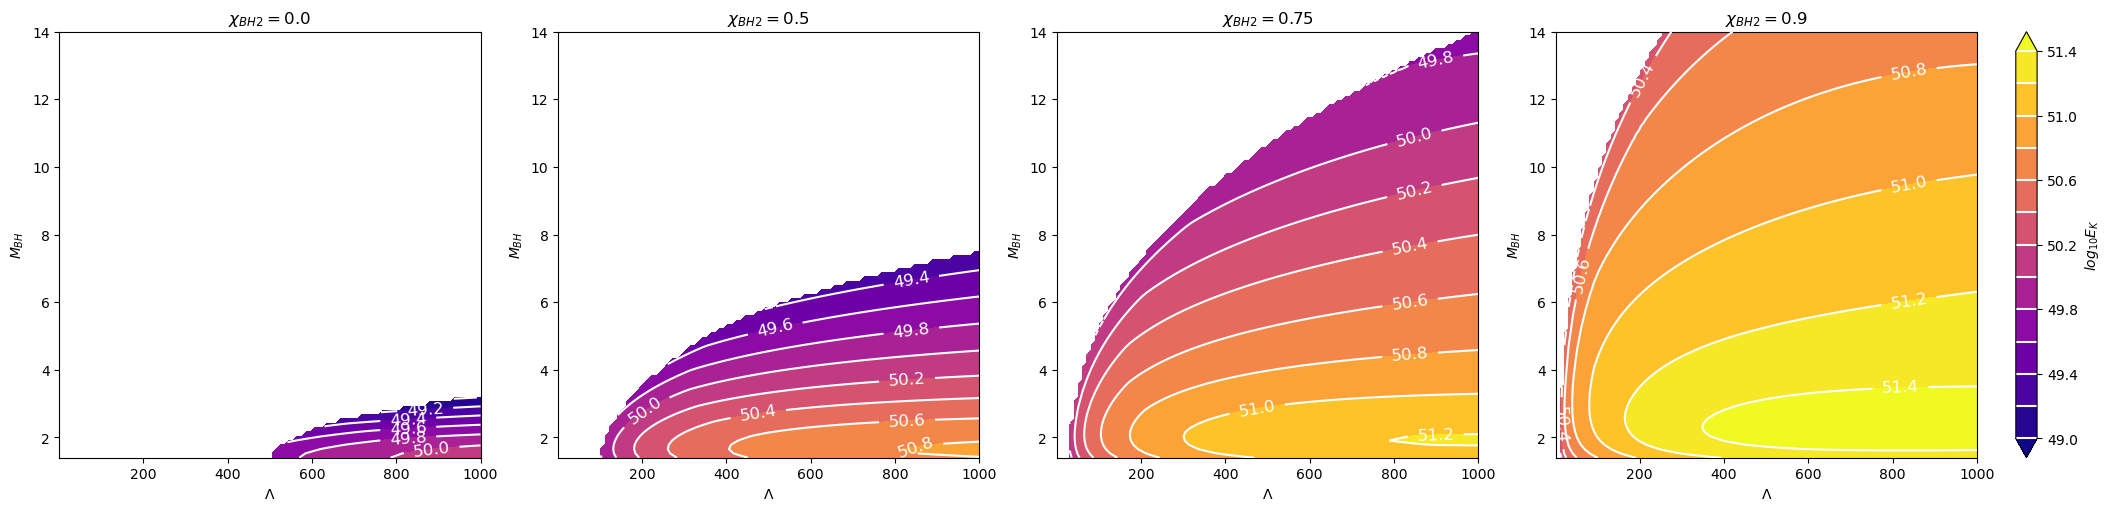

In [14]:
BH_spin_parameters=np.array([0.0,0.5, 0.75, 0.9])
#-------------------------------------------------------------------------------------------

graph_dimension=len(BH_spin_parameters)
figure_len=(graph_dimension*5)+1

#plt.style.use('dark_background') 


fig, ax = plt.subplots(1, graph_dimension, figsize=(figure_len, 5),constrained_layout=True)
X, Y = np.meshgrid(lambda_2,M_BH)


for i in range(graph_dimension):
    
    
    Z=np.log10(Kinetic_energy_vectorized(Y,M_ns,BH_spin_parameters[i],0.05,X, eta_BZ_model="M05"))
    
    mass_threshold = 0.03  # Imposta la soglia desiderata
    mask = np.ma.masked_where(Z < mass_threshold, Z)
    
    levels= np.linspace(49,51.4,13) 
    surface = ax[i].contourf(X, Y, mask, levels, cmap=plt.cm.plasma,extend="both")
    #countours = ax[i].contour(surface, levels=surface.levels, colors='black', )
    countours = ax[i].contour(surface, colors='white', zorder=10, levels=surface.levels)
    inline_labels=ax[i].clabel(countours, countours.levels, inline=True, fontsize=12, colors='white', zorder=10)
    
    ax[i].set_title(r'$\chi _{BH2} =$'+fr'{BH_spin_parameters[i]}')
    ax[i].set_ylabel(r'$M_{BH}$')  
    ax[i].set_xlabel(r'$\Lambda$')


# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(surface)
cbar.ax.set_ylabel(r'$log_{10}E_K$')
# Add the contour line levels to the colorbar
cbar.add_lines(countours)
plt.show()

# Merger rate

In [16]:
from scipy.integrate import quad
from astropy.cosmology import Planck18
import astropy.units as u

#---------- Madau-Dickinson model ----------

def merger_rate_density(z):
    
    """ Returns the merger rate density in Mpc^(-3) yr^(-1)

    Returns:
        _type_: _description_
    """
    a=1.803219571
    b=5.309821767
    c=2.837264101
    phi0=8.765949529
    norm_factor=5.15371118850681
    return ((1+z)**a)/(1+((1+z)/c)**b)*phi0*norm_factor



def differential_comoving_volume_P18(z_m):
    
    speed_light = 299792.458 #km/s
    D_H = (speed_light/Planck18.H(0).value)/10**3 #Gpc

    Omega_m = 0.3
    Omega_k = 0
    Omega_Lambda = 1-Omega_m

    def E(z_m): #Redshift z_m
        return np.sqrt((1+z_m)**3*Omega_m+(1+z_m)**2*Omega_k+Omega_Lambda)
    

    return 4*np.pi*D_H*(((1+z_m)**2*(Planck18.angular_diameter_distance(z_m).value/10**3)**2)/(E(z_m))) # Gpc^3


def merger_rate_cumulative(z_min,z_max):
    
    z_values = np.linspace(z_min, z_max, 1000)  # Modifica i limiti in base alle tue esigenze
    
    def integrand(z):
        dV_dz = differential_comoving_volume_P18(z)
        conversion_factor=1/(1+z)
        merger_rate=merger_rate_density(z)
        #merger_density = u.Quantity(merger_rate, unit=u.Gpc**-3)
        #merger_density_mpc3 = merger_density.to(u.Mpc**-3).value
    
        return merger_rate*conversion_factor*dV_dz 

    rate_values = np.array([quad(integrand, 0, z)[0] for z in z_values])
    rate_errors = np.array([quad(integrand, 0, z)[1] for z in z_values])
    
    return  rate_values, rate_errors
    
def merger_rate(z_min,z_max):

    
    def integrand(z):
        dV_dz = differential_comoving_volume_P18(z)
        conversion_factor=1/(1+z)
        merger_rate=merger_rate_density(z)
        #merger_density = u.Quantity(merger_rate, unit=u.Gpc**-3)
        #merger_density_mpc3 = merger_density.to(u.Mpc**-3).value
    
        return merger_rate*conversion_factor*dV_dz 

    rate_value= quad(integrand, z_min, z_max)[0] 
    rate_error = quad(integrand, z_min, z_max)[1]
    
    return  rate_value, rate_error

In [48]:
z_numbers_for_shells=11
min_value = 0.01
max_value = 10

z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
z_shells= np.insert(np.round(z_shells,2), 0, 0)
print(f"Array of shells edges:{z_shells}")
print("")
print(z_shells[:10])

Array of shells edges:[ 0.    0.01  0.02  0.04  0.08  0.16  0.32  0.63  1.26  2.51  5.01 10.  ]

[0.   0.01 0.02 0.04 0.08 0.16 0.32 0.63 1.26 2.51]


In [49]:
print(z_shells)

events_per_shell_non_int=np.zeros(len(z_shells)-1)

for i in range(len(z_shells)-1):
 
    min_z=z_shells[i]
    max_z=z_shells[i+1] 
    
    events_per_shell_non_int[i]=merger_rate(min_z,max_z)[0] # 1/12 stands for 1 month

print(f" Expected events per shell array:{ events_per_shell_non_int=}")
print("")

eventi_possibili_per_shell_int = [np.random.poisson(events) for events in events_per_shell_non_int]
print(f"Number of events per shell:{eventi_possibili_per_shell_int}")
print("")

[ 0.    0.01  0.02  0.04  0.08  0.16  0.32  0.63  1.26  2.51  5.01 10.  ]
 Expected events per shell array: events_per_shell_non_int=array([1.63797682e-02, 1.14506775e-01, 9.13478009e-01, 7.25764010e+00,
       5.69968189e+01, 4.32184514e+02, 2.80757741e+03, 1.44076078e+04,
       3.15133717e+04, 1.52058247e+04, 1.97973695e+03])

Number of events per shell:[0, 0, 0, 8, 66, 401, 2729, 14398, 31557, 14962, 2041]



### GRB

In [127]:
from decimal import Decimal

def F_SYN_slow(t,E,Ek,theta,**parameters):

    #---------------------------fixed parameters-----------------------------------
    n0=parameters.get('n0')
    p=parameters.get('p')
    epsilon_e=parameters.get('epsilon_e')
    epsilon_B=parameters.get('epsilon_B')
    d_L=parameters.get('d_L')
    z=parameters.get('z')
    b=parameters.get('b')
    theta_Core=parameters.get('theta_Core')
    #------------------------------------------------------------------------------
    #E55=Ek/10**(55)
    d28=d_L/10**(28)
    t2=t/100 #seconds
    h=4.13*10**(-15) #eV s
    B_1=epsilon_B*10 
    e_1=epsilon_e*10 
    #Y=0.93*t2**(-0.09)
    c=2.99792e10 #cm s
    
    from decimal import Decimal
    
    nu=E/h
    #------------------------------------------------------------------------------
    
    E_theta=Ek*(1+theta**2/(b*theta_Core**2))**(-b/2)
    E55=E_theta/10**55
    E52=E_theta/10**52
    #--------------------------------------------------------------------------------------------------------------------------
    t_0_IC=6.3*(1+z)*((epsilon_e/0.5)**3)*(epsilon_B/0.01)*E52*n0*3600 # from hours to seconds
    Y=np.sqrt(epsilon_e/epsilon_B)*(t/t_0_IC)**((2-p)/(2*(4-p)))
    #-------------------------------------------------------------------------------------------------------------------------------------
    
    hnu_a_SYN_slow= 4.4*10**(-4)*((p+2)**(3/5)*(p-1)**(8/5))/((3*p+2)**(3/5)*(p-2))*(1+z)**(-1)*B_1**(1/5)*e_1**(-1)*n0**(3/5)*E55**(1/5)
    
    nu_a_SYN_slow=hnu_a_SYN_slow/h
    #print('nu_a_SYN:', '%.2E' % Decimal(nu_a_SYN_slow))
    
    hnu_m=41.3*((p-2)/(p-1))**2*(1+z)**(1/2)*B_1**(1/2)*e_1**2*E55**(1/2)*t2**(-3/2)*1000
    
    nu_m=hnu_m/h
    #print('nu_m_SYN:', '%.2E' % Decimal(nu_m))
    
    hnu_c=1.0*(1+z)**(-1/2)*B_1**(-3/2)*n0**(-1)*E55**(-1/2)*t2**(-1/2)*(1+Y)**(-2)
    
    nu_c=hnu_c/h
    #print('nu_c_SYN:', '%.2E' % Decimal(nu_c))
    
    #----------------------------------------------------------------------------------------------------------------
    E_cut=t2**(-1/4)*1e9

    #----------------------------------------------------------------------------------------------------------------
    
    f_max=377.1*(1+z)**(-1)*B_1**(1/2)*n0**(1/2)*E55*d28**(-2) #in Jy
    
    Flux=np.zeros(len(nu))
    
    for i in range(len(nu)):
        
    #    f_max_erg=f_max*nu[i]*10**23
        
        if nu[i]<nu_a_SYN_slow:
            
            factor=(nu[i]/nu_a_SYN_slow)**2*(nu_a_SYN_slow/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>=nu_a_SYN_slow and nu[i]<= nu_m:
            
            factor=(nu[i]/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>= nu_m and nu[i]<=nu_c:
            
            factor=(nu[i]/nu_m)**(-(p-1)/2)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
            
        if nu[i]> nu_c:
            
            factor=(nu_c/nu_m)**(-(p-1)/2)*(nu[i]/nu_c)**(-p/2)*math.exp(-nu[i]* h/E_cut)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)


    
    return Flux

In [128]:
def F_SSC_slow(t,E,Ek,theta,**parameters):

    #---------------------------fixed parameters-----------------------------------
    n0=parameters.get('n0')
    p=parameters.get('p')
    epsilon_e=parameters.get('epsilon_e')
    epsilon_B=parameters.get('epsilon_B')
    d_L=parameters.get('d_L')
    z=parameters.get('z')
    b=parameters.get('b')
    theta_Core=parameters.get('theta_Core')
    #-------------------------------------------------------------------------------
    
    #E55=Ek/10**(55)
    d28=d_L/10**(28)
    t2=t/100 #seconds
    h=4.13*10**(-15) #eV s
    B_1=epsilon_B*10  
    e_1=epsilon_e*10 
    Y_GRB090510=0.93*t2**(-0.09)
    c=2.99792e10 #cm s

    nu=E/h
    #-------------angle dependence for structured jet-----------------------------------------------------------
    
    E_theta=Ek*(1+theta**2/(b*theta_Core**2))**(-b/2)
    E55=E_theta/10**55
    E52=E_theta/10**52
    
    t_0_IC=6.3*(1+z)*((epsilon_e/0.5)**3)*(epsilon_B/0.01)*E52*n0*3600 # from hours to seconds
    Y=np.sqrt(epsilon_e/epsilon_B)*(t/t_0_IC)**((2-p)/(2*(4-p)))
    #------------------------------------------------------------------------------------------------------------
    
    nu_a_SSC_slow=(0.7*((p+2)**(3/5)*(p-1)**(-2/5)*(p-2)/(3*p+2)**(3/5))*
                   (1+z)**(-1/4)*B_1*(1/5)*e_1*n0**(7/20)*E55**(9/20)*t2**(-3/4)*10**6)/h
    #print('E a', '%.2E' % Decimal(nu_a_SSC_slow*h))
    
    nu_m=(66.5*(((p-2)/(p-1))**4)*(1+z)**(5/4)*B_1**(1/2)*e_1**4*n0**(-1/4)*E55**(3/4)*t2**(-9/4)*10**(12))/h
    #print('E m', '%.2E' % Decimal(nu_m*h))
    
    nu_c=(0.04*(1+z)**(-3/4)*B_1**(7/2)*n0**(-9/4)*E55**(-5/4)*t2**(-1/4)*(1+Y)**(-4)*10**6)/h
    #print('E cooling', '%.2E' % Decimal(nu_c*h))
    

    #-------------------------------------------------------------------------------------------------------------
    
    #E_cut=1.1*(1+z)**(-3/4)*(n0*10**5)**(3/4)*E55**(3/4)*B_1**(3/2)*t2**(-1/4)*(1+Y)**2# eV
    #E_cut= t2**(-1/4)*(1+Y)**2*1.1*(1+z)**(-3/4)*(n0*10**5)**(3/4)*B_1**(3/2) # eV    there is no E55 dependence, it creates problems but i don't know why
    E_cut= t2**(-1/4)*10**(11)
    nu_cut=E_cut/h
    #print('E cutoff', '%.2E' % Decimal(E_cut))
    
    
    #----------------------------------------------------------------------------------------------------------------
    
    f_max=7.7*10**(-4)*(1+z)**(-5/4)*B_1**(1/2)*n0**(5/4)*E55**(5/4)*d28**(-2)*t2**(1/4) #Jy
        
    Flux=np.zeros(len(nu))
    
    for i in range(len(nu)):
        
    #    f_max_erg=f_max*nu[i]*10**23
        
        if nu[i]<nu_a_SSC_slow:
            
            factor=(nu[i]/nu_a_SSC_slow)**2*(nu_a_SSC_slow/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>=nu_a_SSC_slow and nu[i]<= nu_m:
            
            factor=(nu[i]/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>= nu_m and nu[i]<=nu_c:
            
            factor=(nu[i]/nu_m)**(-(p-1)/2)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
            
        if nu[i]> nu_c:
            
            factor=(nu_c/nu_m)**(-(p-1)/2)*(nu[i]/nu_c)**(-p/2)*math.exp(-nu[i]*h/E_cut)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)
    
    return Flux

# CTA

In [29]:

from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
import gammapy

from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, SensitivityEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.maps.axes import UNIT_STRING_FORMAT

from gammapy.utils.check import check_tutorials_setup

#check_tutorials_setup()

energy_axis = MapAxis.from_energy_bounds(0.03 * u.TeV, 30 * u.TeV, nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    0.01 * u.TeV, 100 * u.TeV, nbin=100, name="energy_true"
)

pointing = SkyCoord(ra=0 * u.deg, dec=0 * u.deg)
pointing_info = FixedPointingInfo(fixed_icrs=pointing)
offset = 0.5 * u.deg

source_position = pointing.directional_offset_by(0 * u.deg, offset)
on_region_radius = 0.1 * u.deg
on_region = CircleSkyRegion(source_position, radius=on_region_radius)

geom = RegionGeom.create(on_region, axes=[energy_axis])
empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

paths=["/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.1800s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs09MSTs.1800s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs09MSTs.18000s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"]

emisphere=["cta_south","cta_south","cta_south","cta_north","cta_north","cta_north"]

exposure=[0.5,5,50,0.5,5,50]

Sens_south1={ "CTA_South_20_1800_E":np.zeros(20),"CTA_South_20_1800_y": np.zeros(20)}
Sens_south2={ "CTA_South_20_18000_E":np.zeros(20),"CTA_South_20_18000_y": np.zeros(20)}
Sens_south3={ "CTA_South_20_180000_E":np.zeros(20),"CTA_South_20_180000_y": np.zeros(20)}

Sens_north1={ "CTA_North_20_1800_E":np.zeros(20),"CTA_North_20_1800_y": np.zeros(20)}
Sens_north2={ "CTA_North_20_18000_E":np.zeros(20),"CTA_North_20_18000_y": np.zeros(20)}
Sens_north3={ "CTA_North_20_180000_E":np.zeros(20),"CTA_North_20_180000_y": np.zeros(20)}

Sens=[Sens_south1,Sens_south2,Sens_south3,Sens_north1,Sens_north2,Sens_north3]


In [30]:
for i in range(len(paths)):
    
    irfs = load_irf_dict_from_file(paths[i])                                                                                
    
    location = observatory_locations[emisphere[i]]
    livetime = exposure[i] * u.h
    obs = Observation.create(
        pointing=pointing_info, irfs=irfs, livetime=livetime, location=location)
    
    spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "edisp", "background"],
    containment_correction=False,
    )
    dataset = spectrum_maker.run(empty_dataset, obs)

    containment = 0.68
    dataset.exposure *= containment

    on_radii = obs.psf.containment_radius(
        energy_true=energy_axis.center, offset=offset, fraction=containment
    )
    factor = (1 - np.cos(on_radii)) / (1 - np.cos(on_region_radius))
    dataset.background *= factor.value.reshape((-1, 1, 1))
    
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
    )

    sensitivity_estimator = SensitivityEstimator(
        gamma_min=10,
        n_sigma=5,
        bkg_syst_fraction=0.05,
    )
    sensitivity_table = sensitivity_estimator.run(dataset_on_off)

    #display(sensitivity_table)
    
    for chiave, array in Sens[i].items():
        if chiave.endswith('_E'): 
            for E,i in zip (sensitivity_table["energy"],range(len(sensitivity_table["energy"]))):
                array[i]=E
        if chiave.endswith('_y'):
            for y,i in zip (sensitivity_table["e2dnde"],range(len(sensitivity_table["e2dnde"]))):
                array[i] = y

In [33]:
def From_Ek_to_Eiso(Ek,theta_c):
    return Ek/(1-np.cos(theta_c))

In [126]:
from scipy.interpolate import interp1d
def confronta_funzioni(y1, x1, y2, x2):
    """
    Confronta due funzioni definite da array di valori y e x
    e restituisce True se la prima funzione è maggiore della seconda
    in almeno un punto nell'intervallo di sovrapposizione degli intervalli di x,
    altrimenti restituisce False.
    """
    # Trova gli estremi degli intervalli di x
    x1_min, x1_max = min(x1), max(x1)
    x2_min, x2_max = min(x2), max(x2)

    # Controlla se gli intervalli si sovrappongono
    if x1_max < x2_min or x1_min > x2_max:
        #print("Gli intervalli non si sovrappongono.")
        return False

    # Trova l'intervallo di sovrapposizione
    x_min = max(x1_min, x2_min)
    x_max = min(x1_max, x2_max)

    # Interpola i valori delle funzioni sugli stessi punti lungo l'asse x
    f1 = interp1d(x1, y1)
    f2 = interp1d(x2, y2)

    # Calcola i valori interpolati nelle corrispondenti coordinate x
    x_interp = np.linspace(x_min, x_max, 100)
    y1_interp = f1(x_interp)
    y2_interp = f2(x_interp)

    # Confronta i valori interpolati delle due funzioni nell'intervallo di sovrapposizione
    for i in range(len(x_interp)):
        if y1_interp[i] > y2_interp[i]:
            #print("La funzione 1 è maggiore della funzione 2 in almeno un punto.")
            return True

    #print("La funzione 1 non è maggiore della funzione 2 in nessun punto.")
    return False

### Test

In [129]:
#z_numbers_for_shells=11
#min_value = 0.01
#max_value = 10

#z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
#z_shells= np.insert(np.round(z_shells,2), 0, 0)
#print(f"Array of shells edges:{z_shells}")
#print("")
#print(z_shells[:10])

et_detected_per_shell=np.zeros(9)
grb_produced_per_shell=np.zeros(9)
cta_plus_ET_produced_per_shell=np.zeros(9)

for i in range(len(z_shells)-2):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations3/'+ dataframe_name
        
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        display(errors_network_ET)
        

        for index, row in  errors_network_ET.iterrows():
                
                et_detected_per_shell[i] += 1  # Aumenta il contatore totale ad ogni iterazione
                #print(row['mass_1'])
                Ek = Kinetic_energy_vectorized(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05")
    
                if Ek >0.0:
                    print(Ek)
                    grb_produced_per_shell[i]+= 1  # Aumenta il contatore sopra soglia se il valore è superiore alla soglia
                    
                    if Ek> 1.0e51:
                        print("GRB powerfull")
                        
                    afterglow_parameters = {'n0':          10**(-5),    # circumburst density in cm^{-3}
                                'p':           2.3,    # electron energy distribution index
                                'epsilon_e':   0.2,    # epsilon_e
                                'epsilon_B':   0.01,   # epsilon_B
                                'd_L':         Planck18.luminosity_distance(row['redshift']).value*3.086*10**24, # Luminosity distance in cm 1.8e28
                                'z':           row['redshift'], #0.9
                                'b':           6,      #power law index
                                'theta_Core':  0.05,    # Half-opening angle in radians
                    }
                    
                    theta_jn=row["theta_jn"]
            
                    E0=From_Ek_to_Eiso(Ek,0.05)
                    
                    t=100  #s

                    Ea=10e-5 # Low Energy in eV
                    Eb=10e13 # High Energy in eV
                    E = np.geomspace(Ea, Eb, num=1000)

                    h=4.13*10**(-15)

                    nua=Ea/h
                    nub=Eb/h
                    nu = np.geomspace(nua, nub, num=1000)
                

                    Flux_syn_razz=F_SYN_slow(t,E,Ek,theta_jn,**afterglow_parameters)
                    
                    Flux_ssc_razz=F_SSC_slow(t,E,Ek,theta_jn,**afterglow_parameters)
                    
                    Total_flux_razz= Flux_syn_razz+Flux_ssc_razz
                    
                    x1=Sens[1]["CTA_South_20_18000_E"]*10**12
                    y1=Sens[1]["CTA_South_20_18000_y"]
                    x2=Sens[4]["CTA_North_20_18000_E"]*10**12
                    y2=Sens[4]["CTA_North_20_18000_y"]
                    
                    if confronta_funzioni(Total_flux_razz,E, y1, x1)==True:
                        
                        cta_plus_ET_produced_per_shell += 1
                        print("Detected")
                                
             #-------------------------------------------------------------------------------------------------------------                    
             #-------------------------------------------------------------------------------------------------------------
    else:
        print("Dataframe not ok")
        continue
    
print(et_detected_per_shell)
print(grb_produced_per_shell)
print(cta_plus_ET_produced_per_shell)

dataframe_z_0.0-0.01
Dataframe not ok
dataframe_z_0.01-0.02
Dataframe not ok
dataframe_z_0.02-0.04
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,400.819124,0.02887,18.79,1.774,130.7,2.017,3.764,0.4061,0.218,4.807,...,0.06157,0.06703,0.03489,0.4734,0.001624,0.04529,0.6328,3.436,1198.0,0.01066


dataframe_z_0.04-0.08
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,202.898193,0.06044,20.77,1.432,279.9,0.9394,3.8160,-0.1312,2.8330,3.378,...,0.05617,0.06546,0.3138,0.7858,0.001824,0.02574,0.4958,0.7784,5428.0,0.01145
1,194.303493,0.06790,25.79,1.944,316.1,1.0600,4.3170,0.1247,0.7891,6.087,...,0.08099,0.08765,0.3682,1.4840,0.004666,0.05368,0.8257,113500.0000,5425.0,0.02149
2,246.161481,0.04487,12.46,1.322,205.5,1.9240,3.1980,-0.7449,0.8748,2.686,...,0.14930,0.11210,0.1546,0.2278,0.002247,0.03152,0.3926,0.7406,1503.0,0.03577
3,235.718974,0.04137,11.61,1.853,189.0,1.8970,1.0830,-1.0750,2.3660,4.497,...,0.20780,0.08956,0.2296,0.4045,0.002687,0.10580,0.8803,78.8700,755.4,0.02046
4,132.654234,0.07593,17.77,1.425,355.5,2.1340,0.9433,-0.8573,0.5004,5.954,...,0.09369,0.08349,0.4846,1.5660,0.004730,0.12390,2.0950,17.0500,6068.0,0.01471


dataframe_z_0.08-0.16
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,116.119585,0.11160,31.230,1.157,535.0,1.2000,2.9590,-0.9959,3.0210,0.7650,...,1.52400,0.51520,1.3040,4.0200,0.017240,0.06712,2.1780,97900.0000,89640.0,0.84010
1,134.946417,0.12550,21.900,1.651,607.3,0.5049,2.2920,0.6733,0.8147,3.4590,...,0.09848,0.06603,9.9310,19.6200,0.002449,0.03734,0.6728,0.6386,1380.0,0.01579
2,112.470959,0.13060,5.441,1.322,634.1,0.5526,2.2960,1.2330,2.3790,4.5190,...,0.51810,0.13590,3.0760,5.1800,0.003394,0.23540,1.2020,59.4800,730.3,0.07209
3,157.970547,0.10880,16.450,1.804,520.6,2.1260,0.8455,0.4069,2.6670,1.7670,...,0.32190,0.27250,0.4902,0.6438,0.004889,0.04098,0.5043,0.6941,358.0,0.25140
4,145.108331,0.10720,16.950,1.527,512.7,0.9734,4.5110,1.4190,0.2675,3.3920,...,1.38900,0.29470,1.4120,1.0280,0.005592,0.05748,0.8295,3.6840,4369.0,0.19420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,98.863775,0.08783,11.120,1.417,414.5,1.5060,4.3390,-0.5173,2.3090,5.6420,...,0.65400,0.77410,0.2701,0.8116,0.015120,0.16010,1.6430,50.7700,4051.0,0.55610
61,131.328440,0.09879,5.275,1.651,469.7,2.2960,5.6000,-0.2621,2.0130,2.9080,...,0.12170,0.13700,0.3011,0.6079,0.002117,0.20330,0.7190,5.9250,668.8,0.05019
62,289.093221,0.10040,13.470,1.388,477.8,2.4350,1.3940,0.7931,1.5920,3.5320,...,0.32100,2.12800,0.3421,0.4367,0.003980,0.05892,0.7697,63.8300,2385.0,1.20100
63,56.871072,0.12320,12.150,1.455,595.4,1.4810,4.2900,0.4619,2.7240,3.3440,...,0.19840,0.48620,0.2019,0.6992,0.010370,0.10600,1.1960,1.7570,1194.0,0.16500


1.7444754381388854e+49
5.126650279244143e+48
6.2712924434621e+49
4.690403150750823e+48
3.1233486893140846e+49
2.78143515919056e+48
5.141551528908414e+50
6.427473184682616e+49
dataframe_z_0.16-0.32
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,90.378070,0.2595,23.880,1.808,1357.0,1.0240,5.921000,-0.7189,0.98260,4.7500,...,2.59300,3.31100,2.1980,4.306,0.022180,0.16560,2.583,3254.000,11910.0,12.02000
1,64.681006,0.2826,7.095,1.201,1496.0,0.6439,4.079000,-1.4330,2.52800,0.3563,...,3.60700,0.96080,5.1750,4.030,0.014020,0.20290,1.523,16.670,1462.0,1.41800
2,23.479810,0.3095,6.283,1.460,1661.0,1.7730,0.007279,0.2816,0.21460,3.2250,...,2.41900,4.74200,2.1260,2.520,0.024000,0.99750,5.359,194.000,2006.0,11.01000
3,52.623829,0.2774,19.210,1.737,1465.0,1.2070,0.988200,0.5685,2.18300,4.1980,...,1.25500,2.06000,1.3080,5.163,0.024610,0.29480,3.937,114.100,11060.0,6.71400
4,52.133521,0.2178,9.023,1.146,1114.0,2.0610,2.957000,1.3370,1.65900,4.1670,...,5.06900,0.50870,4.8380,1.871,0.018980,0.41900,4.672,38.110,6370.0,1.59400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24.624291,0.2418,25.570,1.364,1253.0,1.3170,3.625000,0.6597,0.20570,2.3500,...,0.61600,0.26830,0.3221,7.251,0.023710,0.25480,6.100,14.740,103300.0,0.38900
428,131.781290,0.2232,28.960,1.370,1145.0,2.5670,0.118000,0.5073,2.07500,1.7590,...,0.79060,0.91910,3.8700,8.855,0.010100,0.06401,1.733,3.882,1668.0,1.69800
429,26.356594,0.2916,7.058,1.356,1551.0,2.2260,2.056000,0.2744,2.23100,4.7480,...,0.05935,0.05958,2.0420,3.898,0.004059,0.41040,2.686,9.871,1522.0,0.01067
430,33.066309,0.2720,18.830,1.589,1432.0,1.4700,5.482000,0.8439,2.68800,3.8390,...,3.61500,0.82930,3.0340,2.983,0.046670,0.20790,3.187,8.046,18310.0,4.35800


2.8669735443161413e+48
3.5588383454557974e+48
2.4462677479431158e+48
2.6778475724618197e+49
1.5744634678324225e+50
8.583757138670316e+48
6.207489328256681e+49
1.6144730205812573e+50
1.0331714754823185e+50
2.279219730351625e+49
2.018992285362978e+49
6.378835384117502e+49
1.3228780143249939e+50
3.656070948111577e+50
2.1043777921815247e+49
1.097039973868575e+50
3.7231668370321404e+49
1.1945622882190549e+50
2.318329267162032e+50
8.182571959431948e+48
1.7258470340485733e+50
1.167327976973514e+49
4.506459403058109e+49
3.1942334951931244e+50
7.085572641221585e+49
5.180014388183359e+49
6.071121520564896e+49
1.0186678472829698e+50
2.4370077940974675e+49
4.842156337924138e+49
5.103542403322279e+49
3.357509811221213e+50
1.1676662147151379e+49
4.813888461217852e+49
4.9063847134992515e+48
7.380727870066953e+49
dataframe_z_0.32-0.63
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,60.888773,0.5453,23.540,1.600,3240.0,2.8790,5.163,-1.07300,0.2204,1.33100,...,4.6800,1.6000,372.6000,740.6000,0.034580,0.06409,1.206,1.484,10990.0,10.6900
1,31.474884,0.5066,6.661,1.554,2966.0,1.9400,2.544,0.71460,1.2920,5.73400,...,2.5680,4.3930,1.7730,0.8897,0.007079,0.40040,2.061,12.840,1196.0,26.5100
2,16.255121,0.5168,12.690,1.920,3038.0,1.5210,3.552,-0.48600,0.2576,3.21100,...,4.2800,5.5180,1.0620,5.9460,0.107700,0.89220,7.296,46.320,5696.0,27.9900
3,17.156063,0.5629,24.350,1.313,3366.0,1.5230,3.783,0.09969,0.8746,5.95100,...,8.5440,5.1160,1.7690,13.4400,0.182200,0.45530,10.750,18.120,14520.0,59.2300
4,20.629187,0.4492,23.480,1.249,2570.0,1.3120,4.018,-0.04651,0.7832,1.53900,...,1.2210,1.3290,1.7420,11.2800,0.048010,0.36120,8.511,38.120,141300.0,4.1870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,35.127355,0.4160,20.340,1.500,2346.0,0.5842,1.236,-1.05000,2.3240,4.30600,...,0.7804,0.5869,34.8900,72.2900,0.031010,0.43200,7.279,33.140,22110.0,0.6599
2716,15.322560,0.5621,24.560,1.388,3361.0,1.8170,5.494,0.50410,1.8120,0.09959,...,3.0630,1.2780,1.9690,12.1600,0.056180,0.42960,9.776,11.020,11170.0,10.4000
2717,9.517203,0.4375,6.081,1.172,2490.0,1.5640,4.614,-0.41640,1.0670,3.90700,...,0.3991,1.7250,0.7668,4.7270,0.033710,1.96400,12.960,471.000,8624.0,0.4240
2718,16.022216,0.5936,12.490,1.485,3589.0,1.1850,1.675,-0.39570,2.3340,0.48290,...,2.4070,1.8610,1.9780,12.7300,0.054250,1.37700,15.050,399.200,19530.0,12.5200


1.7448995271380556e+50
3.4540903404781443e+49
1.3849069755758296e+49
2.452432296871803e+49
6.705809496202701e+49
1.7833457930210013e+50
5.7802753841568186e+48
1.1069823463232379e+51
GRB powerfull
7.872390472922361e+48
7.532131510230653e+49
2.0928547436982994e+49
1.5351085609300898e+50
2.8517203768791738e+50
2.722460743850872e+49
1.6977469552285093e+50
2.60098640286379e+50
5.725950913018043e+49
2.428527050065231e+50
6.257563036128463e+49
7.319265310251016e+49
8.053865565924917e+49
3.991747551303462e+49
2.3205655274007575e+50
7.641186742428896e+49
1.5230128484760447e+49
2.507850724734823e+50
3.9214540898226776e+50
3.5576526322942385e+49
4.1429851791187434e+48
4.898589281530893e+49
8.48939685208462e+48
5.451084392577918e+49
1.3920710820066133e+49
1.7880348958352263e+50
1.989942906298251e+49
5.440252816281639e+49
2.1920191940602135e+49
2.794099964101155e+50
3.43043326155499e+50
2.4476204819317975e+48
2.6284513055545903e+50
2.2523726831986054e+50
1.6931100871689864e+49
4.932255487181257e+49

,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,29.691725,0.8732,7.469,1.304,5748.0,0.1714,1.7030,1.368000,2.057000,2.2530,...,6.7180,2.1480,3.330,5.825,0.01986,1.0110,7.311,63.060,3134.0,2.5340
1,51.646693,0.6870,18.170,1.511,4286.0,0.5034,2.4630,0.859600,1.391000,5.9840,...,8.8290,9.3180,18.520,22.750,0.06994,0.3225,4.555,30890.000,14710.0,83.9000
2,23.314626,0.9518,19.120,1.403,6391.0,2.4900,0.3072,-0.142100,1.659000,2.6540,...,3.5090,4.8790,33.440,71.390,0.09176,0.5029,8.382,22.620,26610.0,53.0800
3,14.595609,0.8173,22.080,1.422,5299.0,2.0750,3.5650,0.525400,2.458000,3.1870,...,2.9620,2.7780,5.733,15.700,0.06228,0.3104,6.510,5.644,6382.0,22.3000
4,20.284389,0.8527,10.030,1.613,5583.0,1.2820,4.2450,0.776900,0.492300,4.6450,...,7.9560,9.9200,5.380,8.134,0.03052,1.7630,14.110,90.270,3864.0,176.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8054,23.267291,1.0860,25.530,1.211,7522.0,2.5350,5.0970,-0.122200,0.549000,0.5698,...,3.9920,5.4490,53.210,102.200,0.09014,0.1431,4.108,2.620,1526.0,67.7700
8055,12.146326,0.7251,13.810,1.119,4577.0,2.2680,1.5280,-0.625500,2.908000,1.2070,...,0.6878,0.5436,10.310,30.340,0.06653,1.3010,20.610,164.500,54500.0,0.9354
8056,58.869959,0.6349,22.880,1.590,3894.0,0.4620,4.9250,0.332000,2.314000,3.6500,...,3.3380,10.7500,36.180,67.000,0.07690,0.2423,4.047,9.197,13420.0,82.0600
8057,12.240957,0.9361,21.080,1.157,6261.0,1.6140,1.8360,-0.972700,0.136600,5.3720,...,38.0700,7.2140,31.590,30.830,0.34030,0.6591,14.880,346.900,155500.0,441.4000


5.806061175854379e+49
3.40923164056579e+48
7.126396575053187e+49
4.5099378029486084e+49
4.6584538969121395e+49
1.466137526484144e+49
4.018809841579891e+49
5.5720047319698795e+48
5.098070422655303e+50
3.677325548709859e+49
1.283141902884177e+50
5.034545273343883e+49
1.05048651785551e+50
1.5558182446745838e+50
6.486390344622327e+49
7.187221187490619e+49
9.727053604275257e+49
8.968896792293035e+48
3.4500978264704893e+50
1.5943171062450471e+50
2.107421705250585e+49
1.4641561184492645e+49
3.52697622649819e+50
2.5505711032654746e+48
3.6765164963095523e+50
6.524872756930405e+49
4.246362143941906e+50
3.685835389433305e+49
3.779545008121059e+48
1.8795855651398185e+49
1.0557092196700887e+50
4.24260460728705e+50
5.144040879629732e+50
1.2711322572126011e+49
2.42914253047328e+50
5.091764391198695e+50
8.867160174564641e+49
1.9228165106391951e+49
8.206952917656573e+49
6.250694210011924e+49
1.065909610852573e+50
1.2598072482819273e+50
9.156775238708285e+48
3.7222574448327336e+48
6.548849227631829e+49


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,8.228491,1.334,20.100,1.128,9689.0,1.9120,5.155,0.7202,2.8420,5.245,...,12.220,11.320,8.865,30.630,0.16030,0.7779,16.890,51.650,220200.0,283.60
1,18.977737,1.388,12.100,1.106,10180.0,0.6653,4.744,0.1870,1.8480,1.665,...,6.713,29.380,19.140,43.340,0.30760,0.9446,12.260,38.970,21510.0,598.30
2,17.867947,1.320,10.870,1.263,9562.0,0.9648,3.567,0.8311,1.3870,3.328,...,16.000,38.770,14.070,14.360,0.13630,1.2000,12.240,57.940,12590.0,957.00
3,23.691068,1.281,13.670,1.220,9216.0,0.2477,1.199,-0.2690,1.7950,4.372,...,5.345,7.357,1363.000,2732.000,0.07793,0.3567,5.087,8.840,6533.0,111.60
4,23.199077,1.517,24.530,1.133,11350.0,2.3110,5.228,-0.6016,0.1625,4.079,...,28.550,155.700,26.770,7.067,0.30160,0.1781,4.260,5.788,106500.0,5244.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,8.128234,1.291,10.770,1.158,9307.0,2.1800,2.435,-0.3191,1.3920,1.846,...,3.503,4.035,12.210,41.360,0.12420,2.2450,24.540,2902.000,42630.0,41.81
1010,8.608643,1.522,18.130,1.165,11390.0,1.3110,3.100,0.1262,1.5720,4.097,...,24.310,84.770,9.862,45.820,1.23000,1.2400,22.970,262.500,177600.0,3216.00
1011,8.635731,1.414,9.877,1.168,10410.0,1.7770,1.891,0.8666,1.5840,5.156,...,46.600,13.220,40.110,9.616,0.39790,1.0140,11.220,18.260,5005.0,991.00
1012,21.733184,1.263,12.910,1.297,9060.0,2.4610,2.307,0.4927,2.5440,0.692,...,9.421,13.740,11.440,21.050,0.08380,0.4645,5.690,23.880,15720.0,280.60


6.275499929855763e+49
1.5770603267804805e+50
1.318802117539693e+50
5.1798888998592665e+48
3.654374086022991e+48
2.4857047390483337e+49
9.45668285952917e+49
4.411531822771306e+49
2.324269423100158e+50
1.1701626338488617e+50
5.239283379917946e+49
2.4422497181304296e+50
1.4417065212545322e+50
4.691666050320155e+49
2.2657004559756516e+50
3.283004979106888e+49
2.80326992695532e+49
1.1025231421424674e+50
3.4016043101992794e+49
4.69298840742038e+49
3.3912382882557035e+49
2.2164176480876027e+50
7.619135546046478e+49
1.8785272657161206e+50
5.515151125641086e+49
9.360896944330013e+49
1.4080545472090974e+50
6.649815070581584e+48
3.5376159629816443e+49
1.4501505453004005e+50
6.240587611428621e+49
1.0748352771291127e+50
4.0363325044971414e+49
dataframe_z_2.51-5.01
Dataframe not ok
[0.000e+00 0.000e+00 1.000e+00 5.000e+00 6.500e+01 4.320e+02 2.720e+03
 8.059e+03 1.014e+03]
[  0.   0.   0.   0.   8.  36. 246. 529.  33.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [81]:
#z_numbers_for_shells=11
#min_value = 0.01
#max_value = 10

#z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
#z_shells= np.insert(np.round(z_shells,2), 0, 0)
#print(f"Array of shells edges:{z_shells}")
#print("")
#print(z_shells[:10])

et_detected_per_shell=np.zeros(9)
grb_produced_per_shell=np.zeros(9)
cta_plus_ET_produced_per_shell=np.zeros(9)

for i in range(len(z_shells)-2):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations3/'+ dataframe_name
        
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        display(errors_network_ET)
        

        for index, row in  errors_network_ET.iterrows():
                
                et_detected_per_shell[i] += 1  # Aumenta il contatore totale ad ogni iterazione
                #print(row['mass_1'])
                Ek = Kinetic_energy_vectorized(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05")
    
                if Ek >0.0:
                    print(Ek)
                    grb_produced_per_shell[i]+= 1  # Aumenta il contatore sopra soglia se il valore è superiore alla soglia
                    
                    if Ek> 1.0e51:
                        print("GRB powerfull")
                        
                    afterglow_parameters = {'n0':          10**(-5),    # circumburst density in cm^{-3}
                                'p':           2.3,    # electron energy distribution index
                                'epsilon_e':   0.2,    # epsilon_e
                                'epsilon_B':   0.01,   # epsilon_B
                                'd_L':         Planck18.luminosity_distance(row['redshift']).value*3.086*10**24, # Luminosity distance in cm 1.8e28
                                'z':           row['redshift'], #0.9
                                'b':           6,      #power law index
                                'theta_Core':  0.05,    # Half-opening angle in radians
                    }
                    
                    theta_jn=row["theta_jn"]
            
                    E0=From_Ek_to_Eiso(Ek,0.05)
                    
                    t=100  #s

                    Ea=10e-5 # Low Energy in eV
                    Eb=10e13 # High Energy in eV
                    E = np.geomspace(Ea, Eb, num=1000)

                    h=4.13*10**(-15)

                    nua=Ea/h
                    nub=Eb/h
                    nu = np.geomspace(nua, nub, num=1000)
                

                    Flux_syn_razz=F_SYN_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                    
                    Flux_ssc_razz=F_SSC_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                    
                    Total_flux_razz= Flux_syn_razz+Flux_ssc_razz
                    
                    x1=Sens[1]["CTA_South_20_18000_E"]*10**12
                    y1=Sens[1]["CTA_South_20_18000_y"]
                    x2=Sens[4]["CTA_North_20_18000_E"]*10**12
                    y2=Sens[4]["CTA_North_20_18000_y"]
                
                    min_x1 = np.min(x1)
                    max_x1 = np.max(x1)
                    
                    for e in range(len(E)):
                        if min_x1 <= E[i] <= max_x1 :
                            if Total_flux_razz[i] > np.interp(E[e], x1, y1):
                                
                                cta_plus_ET_produced_per_shell += 1
                                print("Detected")
                                
             #-------------------------------------------------------------------------------------------------------------                    
             #-------------------------------------------------------------------------------------------------------------
    else:
        print("Dataframe not ok")
        continue
    
print(et_detected_per_shell)
print(grb_produced_per_shell)
print(cta_plus_ET_produced_per_shell)

dataframe_z_0.0-0.01
Dataframe not ok
dataframe_z_0.01-0.02
Dataframe not ok
dataframe_z_0.02-0.04
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,400.819124,0.02887,18.79,1.774,130.7,2.017,3.764,0.4061,0.218,4.807,...,0.06157,0.06703,0.03489,0.4734,0.001624,0.04529,0.6328,3.436,1198.0,0.01066


dataframe_z_0.04-0.08
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,202.898193,0.06044,20.77,1.432,279.9,0.9394,3.8160,-0.1312,2.8330,3.378,...,0.05617,0.06546,0.3138,0.7858,0.001824,0.02574,0.4958,0.7784,5428.0,0.01145
1,194.303493,0.06790,25.79,1.944,316.1,1.0600,4.3170,0.1247,0.7891,6.087,...,0.08099,0.08765,0.3682,1.4840,0.004666,0.05368,0.8257,113500.0000,5425.0,0.02149
2,246.161481,0.04487,12.46,1.322,205.5,1.9240,3.1980,-0.7449,0.8748,2.686,...,0.14930,0.11210,0.1546,0.2278,0.002247,0.03152,0.3926,0.7406,1503.0,0.03577
3,235.718974,0.04137,11.61,1.853,189.0,1.8970,1.0830,-1.0750,2.3660,4.497,...,0.20780,0.08956,0.2296,0.4045,0.002687,0.10580,0.8803,78.8700,755.4,0.02046
4,132.654234,0.07593,17.77,1.425,355.5,2.1340,0.9433,-0.8573,0.5004,5.954,...,0.09369,0.08349,0.4846,1.5660,0.004730,0.12390,2.0950,17.0500,6068.0,0.01471


dataframe_z_0.08-0.16
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,116.119585,0.11160,31.230,1.157,535.0,1.2000,2.9590,-0.9959,3.0210,0.7650,...,1.52400,0.51520,1.3040,4.0200,0.017240,0.06712,2.1780,97900.0000,89640.0,0.84010
1,134.946417,0.12550,21.900,1.651,607.3,0.5049,2.2920,0.6733,0.8147,3.4590,...,0.09848,0.06603,9.9310,19.6200,0.002449,0.03734,0.6728,0.6386,1380.0,0.01579
2,112.470959,0.13060,5.441,1.322,634.1,0.5526,2.2960,1.2330,2.3790,4.5190,...,0.51810,0.13590,3.0760,5.1800,0.003394,0.23540,1.2020,59.4800,730.3,0.07209
3,157.970547,0.10880,16.450,1.804,520.6,2.1260,0.8455,0.4069,2.6670,1.7670,...,0.32190,0.27250,0.4902,0.6438,0.004889,0.04098,0.5043,0.6941,358.0,0.25140
4,145.108331,0.10720,16.950,1.527,512.7,0.9734,4.5110,1.4190,0.2675,3.3920,...,1.38900,0.29470,1.4120,1.0280,0.005592,0.05748,0.8295,3.6840,4369.0,0.19420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,98.863775,0.08783,11.120,1.417,414.5,1.5060,4.3390,-0.5173,2.3090,5.6420,...,0.65400,0.77410,0.2701,0.8116,0.015120,0.16010,1.6430,50.7700,4051.0,0.55610
61,131.328440,0.09879,5.275,1.651,469.7,2.2960,5.6000,-0.2621,2.0130,2.9080,...,0.12170,0.13700,0.3011,0.6079,0.002117,0.20330,0.7190,5.9250,668.8,0.05019
62,289.093221,0.10040,13.470,1.388,477.8,2.4350,1.3940,0.7931,1.5920,3.5320,...,0.32100,2.12800,0.3421,0.4367,0.003980,0.05892,0.7697,63.8300,2385.0,1.20100
63,56.871072,0.12320,12.150,1.455,595.4,1.4810,4.2900,0.4619,2.7240,3.3440,...,0.19840,0.48620,0.2019,0.6992,0.010370,0.10600,1.1960,1.7570,1194.0,0.16500


1.7444754381388854e+49
5.126650279244143e+48
6.2712924434621e+49
4.690403150750823e+48
3.1233486893140846e+49
2.78143515919056e+48
5.141551528908414e+50
6.427473184682616e+49
dataframe_z_0.16-0.32
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,90.378070,0.2595,23.880,1.808,1357.0,1.0240,5.921000,-0.7189,0.98260,4.7500,...,2.59300,3.31100,2.1980,4.306,0.022180,0.16560,2.583,3254.000,11910.0,12.02000
1,64.681006,0.2826,7.095,1.201,1496.0,0.6439,4.079000,-1.4330,2.52800,0.3563,...,3.60700,0.96080,5.1750,4.030,0.014020,0.20290,1.523,16.670,1462.0,1.41800
2,23.479810,0.3095,6.283,1.460,1661.0,1.7730,0.007279,0.2816,0.21460,3.2250,...,2.41900,4.74200,2.1260,2.520,0.024000,0.99750,5.359,194.000,2006.0,11.01000
3,52.623829,0.2774,19.210,1.737,1465.0,1.2070,0.988200,0.5685,2.18300,4.1980,...,1.25500,2.06000,1.3080,5.163,0.024610,0.29480,3.937,114.100,11060.0,6.71400
4,52.133521,0.2178,9.023,1.146,1114.0,2.0610,2.957000,1.3370,1.65900,4.1670,...,5.06900,0.50870,4.8380,1.871,0.018980,0.41900,4.672,38.110,6370.0,1.59400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24.624291,0.2418,25.570,1.364,1253.0,1.3170,3.625000,0.6597,0.20570,2.3500,...,0.61600,0.26830,0.3221,7.251,0.023710,0.25480,6.100,14.740,103300.0,0.38900
428,131.781290,0.2232,28.960,1.370,1145.0,2.5670,0.118000,0.5073,2.07500,1.7590,...,0.79060,0.91910,3.8700,8.855,0.010100,0.06401,1.733,3.882,1668.0,1.69800
429,26.356594,0.2916,7.058,1.356,1551.0,2.2260,2.056000,0.2744,2.23100,4.7480,...,0.05935,0.05958,2.0420,3.898,0.004059,0.41040,2.686,9.871,1522.0,0.01067
430,33.066309,0.2720,18.830,1.589,1432.0,1.4700,5.482000,0.8439,2.68800,3.8390,...,3.61500,0.82930,3.0340,2.983,0.046670,0.20790,3.187,8.046,18310.0,4.35800


2.8669735443161413e+48
3.5588383454557974e+48
2.4462677479431158e+48
2.6778475724618197e+49
1.5744634678324225e+50
8.583757138670316e+48
6.207489328256681e+49
1.6144730205812573e+50
1.0331714754823185e+50
2.279219730351625e+49
2.018992285362978e+49
6.378835384117502e+49
1.3228780143249939e+50
3.656070948111577e+50
2.1043777921815247e+49
1.097039973868575e+50
3.7231668370321404e+49
1.1945622882190549e+50
2.318329267162032e+50
8.182571959431948e+48
1.7258470340485733e+50
1.167327976973514e+49
4.506459403058109e+49
3.1942334951931244e+50
7.085572641221585e+49
5.180014388183359e+49
6.071121520564896e+49
1.0186678472829698e+50
2.4370077940974675e+49
4.842156337924138e+49
5.103542403322279e+49
3.357509811221213e+50
1.1676662147151379e+49
4.813888461217852e+49
4.9063847134992515e+48
7.380727870066953e+49
dataframe_z_0.32-0.63
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,60.888773,0.5453,23.540,1.600,3240.0,2.8790,5.163,-1.07300,0.2204,1.33100,...,4.6800,1.6000,372.6000,740.6000,0.034580,0.06409,1.206,1.484,10990.0,10.6900
1,31.474884,0.5066,6.661,1.554,2966.0,1.9400,2.544,0.71460,1.2920,5.73400,...,2.5680,4.3930,1.7730,0.8897,0.007079,0.40040,2.061,12.840,1196.0,26.5100
2,16.255121,0.5168,12.690,1.920,3038.0,1.5210,3.552,-0.48600,0.2576,3.21100,...,4.2800,5.5180,1.0620,5.9460,0.107700,0.89220,7.296,46.320,5696.0,27.9900
3,17.156063,0.5629,24.350,1.313,3366.0,1.5230,3.783,0.09969,0.8746,5.95100,...,8.5440,5.1160,1.7690,13.4400,0.182200,0.45530,10.750,18.120,14520.0,59.2300
4,20.629187,0.4492,23.480,1.249,2570.0,1.3120,4.018,-0.04651,0.7832,1.53900,...,1.2210,1.3290,1.7420,11.2800,0.048010,0.36120,8.511,38.120,141300.0,4.1870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,35.127355,0.4160,20.340,1.500,2346.0,0.5842,1.236,-1.05000,2.3240,4.30600,...,0.7804,0.5869,34.8900,72.2900,0.031010,0.43200,7.279,33.140,22110.0,0.6599
2716,15.322560,0.5621,24.560,1.388,3361.0,1.8170,5.494,0.50410,1.8120,0.09959,...,3.0630,1.2780,1.9690,12.1600,0.056180,0.42960,9.776,11.020,11170.0,10.4000
2717,9.517203,0.4375,6.081,1.172,2490.0,1.5640,4.614,-0.41640,1.0670,3.90700,...,0.3991,1.7250,0.7668,4.7270,0.033710,1.96400,12.960,471.000,8624.0,0.4240
2718,16.022216,0.5936,12.490,1.485,3589.0,1.1850,1.675,-0.39570,2.3340,0.48290,...,2.4070,1.8610,1.9780,12.7300,0.054250,1.37700,15.050,399.200,19530.0,12.5200


1.7448995271380556e+50
3.4540903404781443e+49
1.3849069755758296e+49
2.452432296871803e+49
6.705809496202701e+49
1.7833457930210013e+50
5.7802753841568186e+48
1.1069823463232379e+51
GRB powerfull
7.872390472922361e+48
7.532131510230653e+49
2.0928547436982994e+49
1.5351085609300898e+50
2.8517203768791738e+50
2.722460743850872e+49
1.6977469552285093e+50
2.60098640286379e+50
5.725950913018043e+49
2.428527050065231e+50
6.257563036128463e+49
7.319265310251016e+49
8.053865565924917e+49
3.991747551303462e+49
2.3205655274007575e+50
7.641186742428896e+49
1.5230128484760447e+49
2.507850724734823e+50
3.9214540898226776e+50
3.5576526322942385e+49
4.1429851791187434e+48
4.898589281530893e+49
8.48939685208462e+48
5.451084392577918e+49
1.3920710820066133e+49
1.7880348958352263e+50
1.989942906298251e+49
5.440252816281639e+49
2.1920191940602135e+49
2.794099964101155e+50
3.43043326155499e+50
2.4476204819317975e+48
2.6284513055545903e+50
2.2523726831986054e+50
1.6931100871689864e+49
4.932255487181257e+49

,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,29.691725,0.8732,7.469,1.304,5748.0,0.1714,1.7030,1.368000,2.057000,2.2530,...,6.7180,2.1480,3.330,5.825,0.01986,1.0110,7.311,63.060,3134.0,2.5340
1,51.646693,0.6870,18.170,1.511,4286.0,0.5034,2.4630,0.859600,1.391000,5.9840,...,8.8290,9.3180,18.520,22.750,0.06994,0.3225,4.555,30890.000,14710.0,83.9000
2,23.314626,0.9518,19.120,1.403,6391.0,2.4900,0.3072,-0.142100,1.659000,2.6540,...,3.5090,4.8790,33.440,71.390,0.09176,0.5029,8.382,22.620,26610.0,53.0800
3,14.595609,0.8173,22.080,1.422,5299.0,2.0750,3.5650,0.525400,2.458000,3.1870,...,2.9620,2.7780,5.733,15.700,0.06228,0.3104,6.510,5.644,6382.0,22.3000
4,20.284389,0.8527,10.030,1.613,5583.0,1.2820,4.2450,0.776900,0.492300,4.6450,...,7.9560,9.9200,5.380,8.134,0.03052,1.7630,14.110,90.270,3864.0,176.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8054,23.267291,1.0860,25.530,1.211,7522.0,2.5350,5.0970,-0.122200,0.549000,0.5698,...,3.9920,5.4490,53.210,102.200,0.09014,0.1431,4.108,2.620,1526.0,67.7700
8055,12.146326,0.7251,13.810,1.119,4577.0,2.2680,1.5280,-0.625500,2.908000,1.2070,...,0.6878,0.5436,10.310,30.340,0.06653,1.3010,20.610,164.500,54500.0,0.9354
8056,58.869959,0.6349,22.880,1.590,3894.0,0.4620,4.9250,0.332000,2.314000,3.6500,...,3.3380,10.7500,36.180,67.000,0.07690,0.2423,4.047,9.197,13420.0,82.0600
8057,12.240957,0.9361,21.080,1.157,6261.0,1.6140,1.8360,-0.972700,0.136600,5.3720,...,38.0700,7.2140,31.590,30.830,0.34030,0.6591,14.880,346.900,155500.0,441.4000


5.806061175854379e+49
3.40923164056579e+48
7.126396575053187e+49
4.5099378029486084e+49
4.6584538969121395e+49
1.466137526484144e+49
4.018809841579891e+49
5.5720047319698795e+48
5.098070422655303e+50
3.677325548709859e+49
1.283141902884177e+50
5.034545273343883e+49
1.05048651785551e+50
1.5558182446745838e+50
6.486390344622327e+49
7.187221187490619e+49
9.727053604275257e+49
8.968896792293035e+48
3.4500978264704893e+50
1.5943171062450471e+50
2.107421705250585e+49
1.4641561184492645e+49
3.52697622649819e+50
2.5505711032654746e+48
3.6765164963095523e+50
6.524872756930405e+49
4.246362143941906e+50
3.685835389433305e+49
3.779545008121059e+48
1.8795855651398185e+49
1.0557092196700887e+50
4.24260460728705e+50
5.144040879629732e+50
1.2711322572126011e+49
2.42914253047328e+50
5.091764391198695e+50
8.867160174564641e+49
1.9228165106391951e+49
8.206952917656573e+49
6.250694210011924e+49
1.065909610852573e+50
1.2598072482819273e+50
9.156775238708285e+48
3.7222574448327336e+48
6.548849227631829e+49


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,8.228491,1.334,20.100,1.128,9689.0,1.9120,5.155,0.7202,2.8420,5.245,...,12.220,11.320,8.865,30.630,0.16030,0.7779,16.890,51.650,220200.0,283.60
1,18.977737,1.388,12.100,1.106,10180.0,0.6653,4.744,0.1870,1.8480,1.665,...,6.713,29.380,19.140,43.340,0.30760,0.9446,12.260,38.970,21510.0,598.30
2,17.867947,1.320,10.870,1.263,9562.0,0.9648,3.567,0.8311,1.3870,3.328,...,16.000,38.770,14.070,14.360,0.13630,1.2000,12.240,57.940,12590.0,957.00
3,23.691068,1.281,13.670,1.220,9216.0,0.2477,1.199,-0.2690,1.7950,4.372,...,5.345,7.357,1363.000,2732.000,0.07793,0.3567,5.087,8.840,6533.0,111.60
4,23.199077,1.517,24.530,1.133,11350.0,2.3110,5.228,-0.6016,0.1625,4.079,...,28.550,155.700,26.770,7.067,0.30160,0.1781,4.260,5.788,106500.0,5244.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,8.128234,1.291,10.770,1.158,9307.0,2.1800,2.435,-0.3191,1.3920,1.846,...,3.503,4.035,12.210,41.360,0.12420,2.2450,24.540,2902.000,42630.0,41.81
1010,8.608643,1.522,18.130,1.165,11390.0,1.3110,3.100,0.1262,1.5720,4.097,...,24.310,84.770,9.862,45.820,1.23000,1.2400,22.970,262.500,177600.0,3216.00
1011,8.635731,1.414,9.877,1.168,10410.0,1.7770,1.891,0.8666,1.5840,5.156,...,46.600,13.220,40.110,9.616,0.39790,1.0140,11.220,18.260,5005.0,991.00
1012,21.733184,1.263,12.910,1.297,9060.0,2.4610,2.307,0.4927,2.5440,0.692,...,9.421,13.740,11.440,21.050,0.08380,0.4645,5.690,23.880,15720.0,280.60


6.275499929855763e+49
1.5770603267804805e+50
1.318802117539693e+50
5.1798888998592665e+48
3.654374086022991e+48
2.4857047390483337e+49
9.45668285952917e+49
4.411531822771306e+49
2.324269423100158e+50
1.1701626338488617e+50
5.239283379917946e+49
2.4422497181304296e+50
1.4417065212545322e+50
4.691666050320155e+49
2.2657004559756516e+50
3.283004979106888e+49
2.80326992695532e+49
1.1025231421424674e+50
3.4016043101992794e+49
4.69298840742038e+49
3.3912382882557035e+49
2.2164176480876027e+50
7.619135546046478e+49
1.8785272657161206e+50
5.515151125641086e+49
9.360896944330013e+49
1.4080545472090974e+50
6.649815070581584e+48
3.5376159629816443e+49
1.4501505453004005e+50
6.240587611428621e+49
1.0748352771291127e+50
4.0363325044971414e+49
dataframe_z_2.51-5.01
Dataframe not ok
[0.000e+00 0.000e+00 1.000e+00 5.000e+00 6.500e+01 4.320e+02 2.720e+03
 8.059e+03 1.014e+03]
[  0.   0.   0.   0.   8.  36. 246. 529.  33.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [46]:
print(eventi_possibili_per_shell_int)

[0, 1, 0, 8, 71, 409, 2856, 14355, 31463, 15266, 1954]


In [130]:
#z_numbers_for_shells=11
#min_value = 0.01
#max_value = 10

#z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
#z_shells= np.insert(np.round(z_shells,2), 0, 0)
#print(f"Array of shells edges:{z_shells}")
#print("")
#print(z_shells[:10])

ET_COE_detected_per_shell=np.zeros(9)
grb_producedCOE_per_shell=np.zeros(9)
cta_plus_ETC0E_produced_per_shell=np.zeros(9)

for i in range(len(z_shells)-2):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations3/'+ dataframe_name
        
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_CE1_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        display(errors_network_ET)
        

        for index, row in  errors_network_ET.iterrows():
                
                ET_COE_detected_per_shell[i] += 1  # Aumenta il contatore totale ad ogni iterazione
                #print(row['mass_1'])
                Ek = Kinetic_energy_vectorized(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05")
    
                if Ek >0.0:
                    print(Ek)
                    grb_producedCOE_per_shell[i]+= 1  # Aumenta il contatore sopra soglia se il valore è superiore alla soglia
                    
                    if Ek> 1.0e51:
                        print("GRB powerfull")
                        
                    afterglow_parameters = {'n0':          10**(-5),    # circumburst density in cm^{-3}
                                'p':           2.3,    # electron energy distribution index
                                'epsilon_e':   0.2,    # epsilon_e
                                'epsilon_B':   0.01,   # epsilon_B
                                'd_L':         Planck18.luminosity_distance(row['redshift']).value*3.086*10**24, # Luminosity distance in cm 1.8e28
                                'z':           row['redshift'], #0.9
                                'b':           6,      #power law index
                                'theta_Core':  0.05,    # Half-opening angle in radians
                    }
                    
                    theta_jn=row["theta_jn"]
            
                    E0=From_Ek_to_Eiso(Ek,0.05)
                    
                    t=100  #s

                    Ea=10e-5 # Low Energy in eV
                    Eb=10e13 # High Energy in eV
                    E = np.geomspace(Ea, Eb, num=1000)

                    h=4.13*10**(-15)

                    nua=Ea/h
                    nub=Eb/h
                    nu = np.geomspace(nua, nub, num=1000)
                

                    Flux_syn_razz=F_SYN_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                    
                    Flux_ssc_razz=F_SSC_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                    
                    Total_flux_razz= Flux_syn_razz+Flux_ssc_razz
                    
                    x1=Sens[1]["CTA_South_20_18000_E"]*10**12
                    y1=Sens[1]["CTA_South_20_18000_y"]
                    x2=Sens[4]["CTA_North_20_18000_E"]*10**12
                    y2=Sens[4]["CTA_North_20_18000_y"]
                
                    if confronta_funzioni(Total_flux_razz,E, y1, x1)==True:

                        cta_plus_ETC0E_produced_per_shell += 1
                        print("Detected")
                                
             #-------------------------------------------------------------------------------------------------------------                    
             #-------------------------------------------------------------------------------------------------------------
    else:
        print("Dataframe not ok")
        continue
    

print(ET_COE_detected_per_shell)
print(grb_producedCOE_per_shell)
print(cta_plus_ETC0E_produced_per_shell)

dataframe_z_0.0-0.01
Dataframe not ok
dataframe_z_0.01-0.02
Dataframe not ok
dataframe_z_0.02-0.04
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,669.544778,0.02887,18.79,1.774,130.7,2.017,3.764,0.4061,0.218,4.807,...,0.000483,0.003096,0.003145,0.3165,0.001016,0.0322,0.4467,2.41,862.9,0.000003


dataframe_z_0.04-0.08
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,369.653638,0.06044,20.77,1.432,279.9,0.9394,3.8160,-0.1312,2.8330,3.378,...,0.001003,0.003335,0.020450,0.2723,0.000877,0.01684,0.3225,0.5142,3615.0,0.000010
1,234.025902,0.06790,25.79,1.944,316.1,1.0600,4.3170,0.1247,0.7891,6.087,...,0.001169,0.003107,0.012590,1.0330,0.003278,0.04331,0.6759,108000.0000,4542.0,0.000010
2,277.739445,0.04487,12.46,1.322,205.5,1.9240,3.1980,-0.7449,0.8748,2.686,...,0.003290,0.002952,0.005939,0.1267,0.000406,0.01653,0.2107,0.3508,1006.0,0.000011
3,397.156607,0.04137,11.61,1.853,189.0,1.8970,1.0830,-1.0750,2.3660,4.497,...,0.003260,0.017710,0.028880,0.2440,0.000956,0.06237,0.5132,46.7200,448.4,0.000039
4,221.887665,0.07593,17.77,1.425,355.5,2.1340,0.9433,-0.8573,0.5004,5.954,...,0.002106,0.014210,0.039630,0.9882,0.003203,0.08823,1.4840,11.9900,4305.0,0.000045


dataframe_z_0.08-0.16
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,207.969325,0.11160,31.230,1.157,535.0,1.2000,2.9590,-0.9959,3.0210,0.7650,...,0.007371,0.021640,0.021210,2.5270,0.008042,0.04477,1.4640,73180.0000,61150.0,0.000098
1,331.886967,0.12550,21.900,1.651,607.3,0.5049,2.2920,0.6733,0.8147,3.4590,...,0.003207,0.004283,0.392100,0.8354,0.000872,0.01807,0.3228,0.3104,687.0,0.000013
2,149.904330,0.13060,5.441,1.322,634.1,0.5526,2.2960,1.2330,2.3790,4.5190,...,0.008737,0.016010,0.347600,0.7232,0.001211,0.21160,1.0830,56.1300,654.0,0.000071
3,198.892319,0.10880,16.450,1.804,520.6,2.1260,0.8455,0.4069,2.6670,1.7670,...,0.001902,0.011080,0.020930,0.2775,0.000895,0.03353,0.4123,0.5681,301.7,0.000045
4,221.065115,0.10720,16.950,1.527,512.7,0.9734,4.5110,1.4190,0.2675,3.3920,...,0.054660,0.006747,0.049150,0.4904,0.001541,0.04280,0.6160,2.7690,3285.0,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,101.378518,0.08783,11.120,1.417,414.5,1.5060,4.3390,-0.5173,2.3090,5.6420,...,0.008360,0.009365,0.006146,0.7750,0.002468,0.15030,1.5410,47.0500,3794.0,0.000176
61,162.842962,0.09879,5.275,1.651,469.7,2.2960,5.6000,-0.2621,2.0130,2.9080,...,0.003462,0.005811,0.052070,0.1729,0.000459,0.08641,0.3188,2.4890,406.3,0.000039
62,317.110969,0.10040,13.470,1.388,477.8,2.4350,1.3940,0.7931,1.5920,3.5320,...,0.010310,0.008015,0.044020,0.3852,0.001236,0.05118,0.6698,56.3400,2096.0,0.000040
63,74.345938,0.12320,12.150,1.455,595.4,1.4810,4.2900,0.4619,2.7240,3.3440,...,0.004365,0.013480,0.029270,0.4701,0.001559,0.06245,0.7185,0.9534,1024.0,0.000142


1.7444754381388854e+49
5.126650279244143e+48
6.2712924434621e+49
4.690403150750823e+48
3.1233486893140846e+49
2.78143515919056e+48
5.141551528908414e+50
6.427473184682616e+49
dataframe_z_0.16-0.32
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,116.381838,0.2595,23.880,1.808,1357.0,1.0240,5.921000,-0.7189,0.98260,4.7500,...,0.012490,0.03001,0.02601,3.3770,0.010820,0.1396,2.179,2812.000,10320.0,0.000229
1,83.107398,0.2826,7.095,1.201,1496.0,0.6439,4.079000,-1.4330,2.52800,0.3563,...,0.181200,0.01987,0.40910,0.7687,0.001807,0.1698,1.275,13.720,1316.0,0.000288
2,31.028327,0.3095,6.283,1.460,1661.0,1.7730,0.007279,0.2816,0.21460,3.2250,...,0.008441,0.06045,0.02658,1.2730,0.004356,0.4742,2.513,74.770,1580.0,0.001495
3,69.333837,0.2774,19.210,1.737,1465.0,1.2070,0.988200,0.5685,2.18300,4.1980,...,0.007716,0.02942,0.01878,4.2510,0.013710,0.2468,3.318,98.290,9466.0,0.000349
4,82.253100,0.2178,9.023,1.146,1114.0,2.0610,2.957000,1.3370,1.65900,4.1670,...,0.064680,0.03408,0.10470,1.3600,0.004458,0.3378,3.826,32.500,5042.0,0.000294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,38.632834,0.2418,25.570,1.364,1253.0,1.3170,3.625000,0.6597,0.20570,2.3500,...,0.012960,0.10520,0.14300,5.1570,0.016680,0.1888,4.498,11.050,77820.0,0.001789
428,161.920068,0.2232,28.960,1.370,1145.0,2.5670,0.118000,0.5073,2.07500,1.7590,...,0.001886,0.01288,0.23100,1.9380,0.005700,0.0534,1.442,3.233,1440.0,0.000060
429,55.296068,0.2916,7.058,1.356,1551.0,2.2260,2.056000,0.2744,2.23100,4.7480,...,0.017230,0.02161,0.46160,1.5950,0.002607,0.2928,1.914,6.903,1316.0,0.001123
430,79.108847,0.2720,18.830,1.589,1432.0,1.4700,5.482000,0.8439,2.68800,3.8390,...,0.020630,0.02430,0.04146,1.5600,0.004980,0.1128,1.711,4.389,9825.0,0.000270


2.8669735443161413e+48
3.5588383454557974e+48
2.4462677479431158e+48
2.6778475724618197e+49
1.5744634678324225e+50
8.583757138670316e+48
6.207489328256681e+49
1.6144730205812573e+50
1.0331714754823185e+50
2.279219730351625e+49
2.018992285362978e+49
6.378835384117502e+49
1.3228780143249939e+50
3.656070948111577e+50
2.1043777921815247e+49
1.097039973868575e+50
3.7231668370321404e+49
1.1945622882190549e+50
2.318329267162032e+50
8.182571959431948e+48
1.7258470340485733e+50
1.167327976973514e+49
4.506459403058109e+49
3.1942334951931244e+50
7.085572641221585e+49
5.180014388183359e+49
6.071121520564896e+49
1.0186678472829698e+50
2.4370077940974675e+49
4.842156337924138e+49
5.103542403322279e+49
3.357509811221213e+50
1.1676662147151379e+49
4.813888461217852e+49
4.9063847134992515e+48
7.380727870066953e+49
dataframe_z_0.32-0.63
Dataframe ok


,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,94.154357,0.5453,23.540,1.600,3240.0,2.8790,5.163,-1.07300,0.2204,1.33100,...,0.01511,0.024310,12.55000,25.0500,0.003291,0.04873,0.9092,1.132,8313.0,0.000166
1,34.943337,0.5066,6.661,1.554,2966.0,1.9400,2.544,0.71460,1.2920,5.73400,...,0.16310,0.148400,0.09225,0.8227,0.002783,0.33990,1.7610,10.660,1103.0,0.006483
2,17.711498,0.5168,12.690,1.920,3038.0,1.5210,3.552,-0.48600,0.2576,3.21100,...,0.05290,0.073580,0.03612,5.5260,0.018410,0.83150,6.7950,43.440,5413.0,0.006753
3,33.081377,0.5629,24.350,1.313,3366.0,1.5230,3.783,0.09969,0.8746,5.95100,...,0.01766,0.036180,0.04166,7.9240,0.025120,0.28010,6.5220,11.170,9265.0,0.001962
4,34.255766,0.4492,23.480,1.249,2570.0,1.3120,4.018,-0.04651,0.7832,1.53900,...,0.01332,0.035450,0.04873,7.8320,0.024910,0.25920,6.0780,27.980,102000.0,0.001274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,81.145523,0.4160,20.340,1.500,2346.0,0.5842,1.236,-1.05000,2.3240,4.30600,...,0.04180,0.004844,1.05900,5.5170,0.015590,0.25380,4.2620,19.220,12440.0,0.000281
2748,24.534063,0.5621,24.560,1.388,3361.0,1.8170,5.494,0.50410,1.8120,0.09959,...,0.01710,0.054690,0.09169,7.5740,0.023950,0.28800,6.4880,7.423,8370.0,0.001416
2749,12.285317,0.4375,6.081,1.172,2490.0,1.5640,4.614,-0.41640,1.0670,3.90700,...,0.04061,0.141800,0.04418,4.2490,0.012700,1.73100,11.4200,408.600,7864.0,0.016440
2750,31.186362,0.5936,12.490,1.485,3589.0,1.1850,1.675,-0.39570,2.3340,0.48290,...,0.05541,0.030860,0.08648,7.5240,0.024230,0.90470,9.8830,260.300,12570.0,0.003408


1.7448995271380556e+50
3.4540903404781443e+49
1.3849069755758296e+49
2.452432296871803e+49
6.705809496202701e+49
1.7833457930210013e+50
5.7802753841568186e+48
1.1069823463232379e+51
GRB powerfull
7.872390472922361e+48
7.532131510230653e+49
2.0928547436982994e+49
1.5351085609300898e+50
2.8517203768791738e+50
2.722460743850872e+49
1.6977469552285093e+50
2.60098640286379e+50
5.725950913018043e+49
2.428527050065231e+50
6.257563036128463e+49
7.319265310251016e+49
8.053865565924917e+49
3.991747551303462e+49
2.3205655274007575e+50
7.641186742428896e+49
1.5230128484760447e+49
2.507850724734823e+50
3.9214540898226776e+50
3.5576526322942385e+49
4.1429851791187434e+48
4.898589281530893e+49
8.48939685208462e+48
5.451084392577918e+49
1.3920710820066133e+49
1.7880348958352263e+50
1.989942906298251e+49
5.440252816281639e+49
2.1920191940602135e+49
2.794099964101155e+50
3.43043326155499e+50
2.4476204819317975e+48
2.6284513055545903e+50
2.2523726831986054e+50
1.6931100871689864e+49
4.932255487181257e+49

,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,37.782720,0.8732,7.469,1.304,5748.0,0.1714,1.7030,1.368000,2.057000,2.2530,...,0.24280,0.04943,148.50000,297.400,0.009165,0.7871,5.699,49.770,2552.0,0.001448
1,51.977292,0.6870,18.170,1.511,4286.0,0.5034,2.4630,0.859600,1.391000,5.9840,...,0.02864,0.01797,1.10800,7.065,0.021280,0.3111,4.401,30330.000,14540.0,0.000932
2,34.268088,0.9518,19.120,1.403,6391.0,2.4900,0.3072,-0.142100,1.659000,2.6540,...,0.03670,0.04203,0.86780,10.010,0.031820,0.4018,6.733,18.470,20590.0,0.004528
3,28.940527,0.8173,22.080,1.422,5299.0,2.0750,3.5650,0.525400,2.458000,3.1870,...,0.06690,0.02540,0.18010,5.061,0.015770,0.1786,3.717,3.273,3901.0,0.002738
4,21.065952,0.8527,10.030,1.613,5583.0,1.2820,4.2450,0.776900,0.492300,4.6450,...,0.13550,0.05075,0.11230,7.805,0.025080,1.6960,13.580,87.150,3757.0,0.007338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,18.746366,0.7251,13.810,1.119,4577.0,2.2680,1.5280,-0.625500,2.908000,1.2070,...,0.01548,0.22030,1.16700,15.770,0.048700,1.0120,16.000,126.400,42040.0,0.008679
8785,11.580597,0.8904,8.880,1.109,5887.0,1.3730,3.4070,-0.290800,1.097000,3.8230,...,0.04491,0.08766,0.19100,4.231,0.013850,0.5465,5.624,24.200,13010.0,0.009728
8786,64.994723,0.6349,22.880,1.590,3894.0,0.4620,4.9250,0.332000,2.314000,3.6500,...,0.03526,0.09282,1.36800,6.803,0.018970,0.2176,3.678,8.621,12260.0,0.002226
8787,16.425942,0.9361,21.080,1.157,6261.0,1.6140,1.8360,-0.972700,0.136600,5.3720,...,0.03247,0.09365,0.05101,21.380,0.068550,0.5311,12.230,293.100,130700.0,0.005379


5.806061175854379e+49
3.40923164056579e+48
7.126396575053187e+49
4.5099378029486084e+49
1.686440053382247e+49
4.6584538969121395e+49
1.466137526484144e+49
4.018809841579891e+49
5.5720047319698795e+48
5.098070422655303e+50
2.951686291000829e+49
3.677325548709859e+49
1.283141902884177e+50
5.034545273343883e+49
1.05048651785551e+50
1.5558182446745838e+50
6.486390344622327e+49
7.187221187490619e+49
9.727053604275257e+49
5.856550683263612e+49
8.968896792293035e+48
2.613183606020516e+49
3.4500978264704893e+50
1.5943171062450471e+50
2.107421705250585e+49
1.4641561184492645e+49
3.52697622649819e+50
2.5505711032654746e+48
3.6765164963095523e+50
6.524872756930405e+49
4.246362143941906e+50
3.685835389433305e+49
5.113106385765152e+49
3.779545008121059e+48
1.8795855651398185e+49
1.0557092196700887e+50
4.24260460728705e+50
5.144040879629732e+50
1.2711322572126011e+49
2.42914253047328e+50
5.091764391198695e+50
8.867160174564641e+49
1.9228165106391951e+49
8.206952917656573e+49
6.250694210011924e+49
3.

,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_ra,err_dec,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,9.609632,1.334,20.100,1.128,9689.0,1.9120,5.155,0.7202,2.8420,5.245,...,0.12970,0.17900,0.13420,24.050,0.07604,0.6956,15.050,46.770,194900.0,0.017990
1,21.684242,1.388,12.100,1.106,10180.0,0.6653,4.744,0.1870,1.8480,1.665,...,0.06087,0.11260,0.88100,13.930,0.04476,0.8499,11.130,36.110,19470.0,0.010510
2,18.662506,1.320,10.870,1.263,9562.0,0.9648,3.567,0.8311,1.3870,3.328,...,0.11780,0.02781,0.19890,13.570,0.04367,1.1430,11.730,56.340,12070.0,0.006054
3,27.355100,1.281,13.670,1.220,9216.0,0.2477,1.199,-0.2690,1.7950,4.372,...,0.03697,0.02903,40.71000,81.400,0.01527,0.3188,4.539,7.883,5961.0,0.002699
4,24.444101,1.517,24.530,1.133,11350.0,2.3110,5.228,-0.6016,0.1625,4.079,...,0.09226,0.03756,0.27370,6.502,0.02031,0.1608,3.970,5.179,92530.0,0.008125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,8.869842,1.291,10.770,1.158,9307.0,2.1800,2.435,-0.3191,1.3920,1.846,...,0.05748,0.06936,0.52730,29.440,0.09352,2.0750,22.790,2770.000,40550.0,0.011880
1373,10.275437,1.522,18.130,1.165,11390.0,1.3110,3.100,0.1262,1.5720,4.097,...,0.11700,0.19280,0.09937,30.710,0.09673,0.9166,17.020,210.200,139600.0,0.052450
1374,9.139738,1.414,9.877,1.168,10410.0,1.7770,1.891,0.8666,1.5840,5.156,...,0.12290,0.06742,0.11680,9.048,0.02896,0.9539,10.540,17.200,4776.0,0.010780
1375,22.621423,1.263,12.910,1.297,9060.0,2.4610,2.307,0.4927,2.5440,0.692,...,0.04064,0.03311,0.75470,6.333,0.01943,0.4453,5.452,23.100,15130.0,0.002776


9.551938654530397e+49
1.7376545480249687e+49
6.275499929855763e+49
1.5770603267804805e+50
2.3720929445486296e+50
3.286869074297024e+49
1.318802117539693e+50
1.3356174441570537e+49
5.1798888998592665e+48
3.654374086022991e+48
2.4857047390483337e+49
9.45668285952917e+49
1.0509450807709124e+50
3.4318555193678657e+49
4.411531822771306e+49
2.324269423100158e+50
1.1701626338488617e+50
3.302117377522466e+49
5.239283379917946e+49
2.4422497181304296e+50
1.4417065212545322e+50
4.767697679113627e+49
1.1042937237982004e+49
4.33037237025232e+49
2.6223088968193227e+49
4.691666050320155e+49
2.2657004559756516e+50
3.283004979106888e+49
2.80326992695532e+49
5.455506131896728e+49
1.1025231421424674e+50
3.0521983617552786e+49
3.4016043101992794e+49
8.844659002033143e+49
4.69298840742038e+49
3.3912382882557035e+49
2.2164176480876027e+50
7.619135546046478e+49
1.8785272657161206e+50
5.515151125641086e+49
4.257823420637933e+49
3.6338131510646954e+49
9.360896944330013e+49
3.278585051326963e+49
1.8490908107759

In [82]:
new_z_shells=z_shells[:10]
print(new_z_shells)
print(eventi_possibili_per_shell_int)

print(et_detected_per_shell)
print(grb_produced_per_shell)
print(cta_plus_ET_produced_per_shell)

print(ET_COE_detected_per_shell)
print(grb_producedCOE_per_shell)
print(cta_plus_ETC0E_produced_per_shell)

[0.   0.01 0.02 0.04 0.08 0.16 0.32 0.63 1.26 2.51]
[0, 0, 0, 8, 66, 401, 2729, 14398, 31557, 14962, 2041]
[0.000e+00 0.000e+00 1.000e+00 5.000e+00 6.500e+01 4.320e+02 2.720e+03
 8.059e+03 1.014e+03]
[  0.   0.   0.   0.   8.  36. 246. 529.  33.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.000e+00 0.000e+00 1.000e+00 5.000e+00 6.500e+01 4.320e+02 2.752e+03
 8.789e+03 1.377e+03]
[  0.   0.   0.   0.   8.  36. 255. 602.  54.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


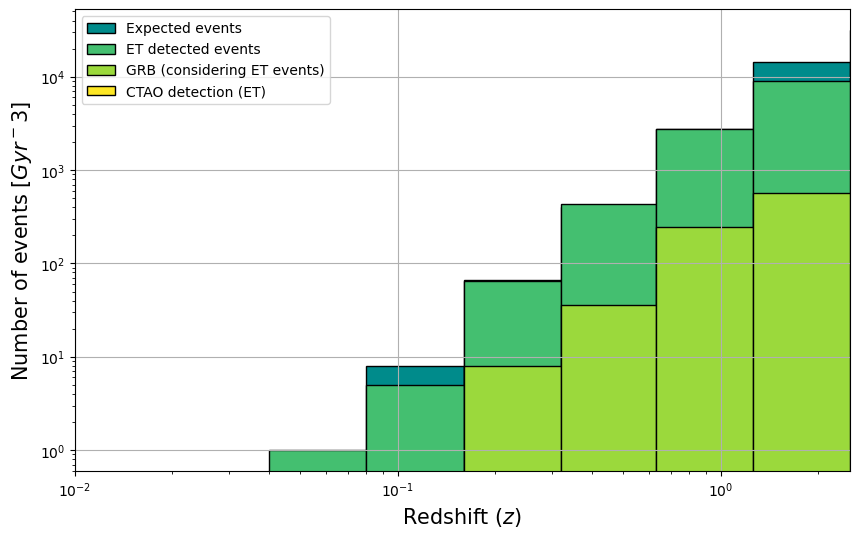

In [88]:
lunghezza_colori = 3


cmap1 = plt.cm.viridis  
colori1 = [cmap1(i) for i in np.linspace(0.7, 1, lunghezza_colori)]

plt.figure(figsize=(10, 6)) 

#plt.hist(z_shells[1:], bins=z_shells, weights=expected_events_per_shell, color='darkcyan', edgecolor='darkgray')
plt.hist(z_shells[1:], bins=z_shells, weights=eventi_possibili_per_shell_int,color='darkcyan', edgecolor='black',label="Expected events")

plt.hist(z_shells[1:10], bins=z_shells[:10], weights=et_detected_per_shell, color=colori1[0], edgecolor='black',label="ET detected events")
plt.hist(z_shells[1:10], bins=z_shells[:10], weights=grb_produced_per_shell, color=colori1[1], edgecolor='black',label="GRB (considering ET events)")
plt.hist(z_shells[1:10], bins=z_shells[:10], weights=cta_plus_ET_produced_per_shell, color=colori1[2], edgecolor='black',label="CTAO detection (ET)")





    
#plt.hist(z_shells[1:], bins=z_shells, weights=normalized_expected_events, color='red', edgecolor='black')
plt.xscale('log')  # Scala logaritmica sull'asse x
plt.yscale('log')  # Scala logaritmica sull'asse y
plt.xlim(0.01,2.51) 
plt.xlabel('Redshift ($z$)',fontsize=15,)
plt.ylabel('Number of events [$Gyr^-3$]',fontsize=15)
plt.legend()
#plt.title('Integrale definito in funzione del redshift')
plt.grid(True)
plt.show()

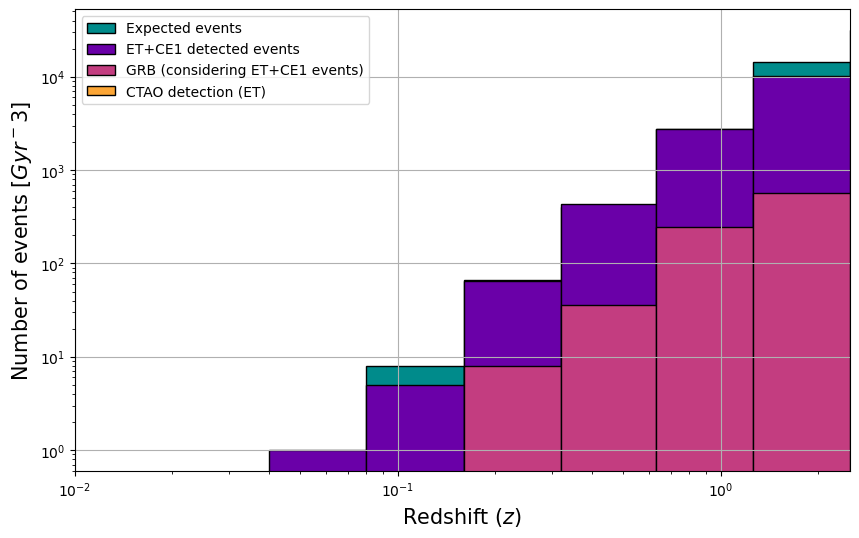

In [91]:
lunghezza_colori2=10

cmap2 = plt.cm.plasma 
colori2 = [cmap2(i) for i in np.linspace(0.2, 0.8, lunghezza_colori2)]

plt.figure(figsize=(10, 6)) 

#plt.hist(z_shells[1:], bins=z_shells, weights=expected_events_per_shell, color='darkcyan', edgecolor='darkgray')
plt.hist(z_shells[1:], bins=z_shells, weights=eventi_possibili_per_shell_int,color='darkcyan', edgecolor='black',label="Expected events")



plt.hist(z_shells[1:10], bins=z_shells[:10], weights=ET_COE_detected_per_shell, color=colori2[0], edgecolor='black',label="ET+CE1 detected events")
plt.hist(z_shells[1:10], bins=z_shells[:10], weights=grb_produced_per_shell, color=colori2[4], edgecolor='black',label="GRB (considering ET+CE1 events)")
plt.hist(z_shells[1:10], bins=z_shells[:10], weights=cta_plus_ET_produced_per_shell, color=colori2[9], edgecolor='black',label="CTAO detection (ET)")




    
#plt.hist(z_shells[1:], bins=z_shells, weights=normalized_expected_events, color='red', edgecolor='black')
plt.xscale('log')  # Scala logaritmica sull'asse x
plt.yscale('log')  # Scala logaritmica sull'asse y
plt.xlim(0.01,2.51) 
plt.xlabel('Redshift ($z$)',fontsize=15,)
plt.ylabel('Number of events [$Gyr^-3$]',fontsize=15)
plt.legend()
#plt.title('Integrale definito in funzione del redshift')
plt.grid(True)
plt.show()

La funzione 1 è maggiore della funzione 2 in almeno un punto.
Risultato: None


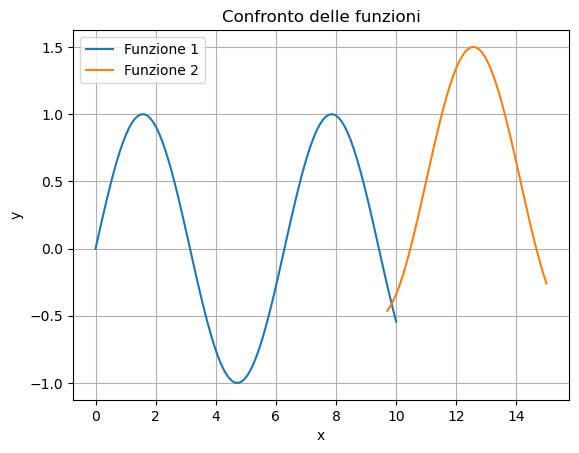

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def confronta_funzioni(y1, x1, y2, x2):
    """
    Confronta due funzioni definite da array di valori y e x
    e restituisce True se la prima funzione è maggiore della seconda
    in almeno un punto nell'intervallo di sovrapposizione degli intervalli di x,
    altrimenti restituisce False.
    """
    # Trova gli estremi degli intervalli di x
    x1_min, x1_max = min(x1), max(x1)
    x2_min, x2_max = min(x2), max(x2)

    # Controlla se gli intervalli si sovrappongono
    if x1_max < x2_min or x1_min > x2_max:
        print("Gli intervalli non si sovrappongono.")
        return False

    # Trova l'intervallo di sovrapposizione
    x_min = max(x1_min, x2_min)
    x_max = min(x1_max, x2_max)

    # Interpola i valori delle funzioni sugli stessi punti lungo l'asse x
    f1 = interp1d(x1, y1)
    f2 = interp1d(x2, y2)

    # Calcola i valori interpolati nelle corrispondenti coordinate x
    x_interp = np.linspace(x_min, x_max, 100)
    y1_interp = f1(x_interp)
    y2_interp = f2(x_interp)

    # Confronta i valori interpolati delle due funzioni nell'intervallo di sovrapposizione
    for i in range(len(x_interp)):
        if y1_interp[i] > y2_interp[i]:
            print("La funzione 1 è maggiore della funzione 2 in almeno un punto.")
            return 

    #print("La funzione 1 non è maggiore della funzione 2 in nessun punto.")
    return 

# Esempio di utilizzo
x1 = np.linspace(0, 10, 100)
y1 = np.sin(x1)

x2 = np.linspace(9.7, 15, 60)
y2 = np.cos(x2)+0.5

risultato = confronta_funzioni(y1, x1, y2, x2)
print("Risultato:", risultato)


plt.plot(x1, y1, label='Funzione 1')
plt.plot(x2, y2, label='Funzione 2')
plt.xlabel('x')   
plt.ylabel('y')
plt.title('Confronto delle funzioni')
plt.legend()
plt.grid(True)
plt.show()